# PEC 3 DISEÑO E IMPLEMENTACIÓN DEL TRABAJO

## TFM GESTIÓN AVANZADA DE INVENTARIO. Machine Learning aplicado a la predicción de la demanda.  

### 3 Diseño modelos de predicción

Se han completado las primeras fases de preparación del fichero, análisis estadístico y temporal, y por último reducción de la dimensionalidad.  
Se aborda en este apartado, el diseño de un modelo de predicción de unidades de venta, a partir de algoritmos Machine learning.   

In [171]:
# Carga de librerías.

import numpy as np 
import pandas as pd
import seaborn as sns
import datetime
from datetime import datetime, timedelta
from pandas import DataFrame, Timestamp

from sklearn import datasets
from sklearn import preprocessing 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor
from sklearn.utils import check_random_state
from scipy import stats
from scipy.stats import norm

# Visualizar árboles
from IPython.display import Image
import pydotplus
from six import StringIO

# UMAP para la reducción de dimensionalidad
# import umap

# Visualización
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# visualizar heatmap
import seaborn as sn

# Validación cruzada
from sklearn.model_selection import StratifiedKFold

# Redes neuronales
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Input
from keras.optimizers import Adam, SGD, Adadelta, Adagrad

%matplotlib inline

In [3]:
# Eliminación de los límites para visualización.

pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [4]:
# Lectura del fichero depurado y limpio.
# Indexar por variable 'date'

venta = pd.read_excel('data/venta_4.xls')
venta = venta.set_index('date')
# venta.sort_index()
# venta = venta.drop(columns = ['Unnamed: 0'], axis=1)

In [4]:
# Se eliminan las filas creadas por hueco en fecha.

# venta = venta.drop(venta[venta['fecha']==1].index, axis = 0)

In [5]:
venta.head()

sku     fecha  udsVenta  bolOpen  bolPromo  udsStock  day  \
date                                                                    
2020-05-19    1  20200519        35        1         0       441   19   
2020-05-20    1  20200520        28        1         0       406   20   
2020-05-21    1  20200521        63        1         0       378   21   
2020-05-22    1  20200522        42        1         0       315   22   
2020-05-23    1  20200523        28        1         0       273   23   

            week_year  monday  tuesday  wednesday  thursday  friday  saturday  \
date                                                                            
2020-05-19         21       0        1          0         0       0         0   
2020-05-20         21       0        0          1         0       0         0   
2020-05-21         21       0        0          0         1       0         0   
2020-05-22         21       0        0          0         0       1         0   
2020-05-23         21       0        0          0         0       0         1   

            sunday  month_1  month_2  month_3  month_4  month_5  month_6  \
date                                                                       
2020-05-19       0        0        0        0        0        1        0   
2020-05-20       0        0        0        0        0        1        0   
2020-05-21       0        0        0        0        0        1        0   
2020-05-22       0        0        0        0        0        1        0   
2020-05-23       0        0        0        0        0        1        0   

            month_7  8  9  10  11  12  2020  2021  2022  bol_weekfirst  \
date                                                                     
2020-05-19        0  0  0   0   0   0     1     0     0              0   
2020-05-20        0  0  0   0   0   0     1     0     0              0   
2020-05-21        0  0  0   0   0   0     1     0     0              0   
2020-05-22        0  0  0   0   0   0     1     0     0              0   
2020-05-23        0  0  0   0   0   0     1     0     0              0   

            bol_weeklast  udsVentalog  bol_festivo  bol_puente  \
date                                                             
2020-05-19             0     3.583519            0           0   
2020-05-20             0     3.367296            0           0   
2020-05-21             0     4.158883            0           0   
2020-05-22             0     3.761200            0           0   
2020-05-23             0     3.367296            0           0   

            bol_week_prev1  bol_week_prev2  bol_week_post1  bol_week_post2  \
date                                                                         
2020-05-19               0               0               0               0   
2020-05-20               0               0               0               0   
2020-05-21               0               0               0               0   
2020-05-22               0               0               0               0   
2020-05-23               0               0               0               0   

            bol_day_prev1  bol_day_prev2  bol_day_post1  bol_day_post2  \
date                                                                     
2020-05-19              0              0              0              0   
2020-05-20              0              0              0              0   
2020-05-21              0              0              0              0   
2020-05-22              0              0              0              0   
2020-05-23              0              0              0              0   

            bol_summer1q  bol_summer2q  bol_summer3q  bol_summer4q  
date                                                                
2020-05-19             0             0             0             0  
2020-05-20             0             0             0             0  
2020-05-21             0             0             0             0  
2020-0

In [6]:
print ('Dimensión del fichero venta {}.'.format(venta.shape))

Dimensión del fichero venta (32236, 47).


### 3.1 Discretizar variable objetivo udsVenta
Los algoritmos de Machine Learning, funcionan mejor en problemas de clasificación, donde la variable objetivo es discreta. En este ejercicio, la variable objetivo udsVenta es continua y debe transformarse en continua. Se discretiza según criterio de tamaño o frecuencia.   

#### 3.1.1 Discretización en 7 intervalos de igual longitud.   
Se crean rangos de manera que cada intervalo represente el mismo número de valores. 

In [7]:
print('El valor máximo de udsVenta es {} y el mínimo {}.'. format(venta['udsVenta'].max(), venta['udsVenta'].min()))

El valor máximo de udsVenta es 273 y el mínimo 0.


El valor máximo de la variable udsVenta es 273 y el mínimo 0. Se reparte el rango de valores, en 7 intervalos de igual tamaño.  

In [8]:
venta['udsVenta_cat'] = pd.cut(venta.udsVenta, bins=7, labels=np.arange(7), right=False)

In [9]:
venta['udsVenta_cat'].describe()

count     32236
unique        7
top           0
freq      29718
Name: udsVenta_cat, dtype: int64

In [10]:
freq_cat = venta['udsVenta_cat'].value_counts()
freq_cat

0    29718
1     2320
2      163
3       28
4        3
6        2
5        2
Name: udsVenta_cat, dtype: int64

La distribución de clases está muy sesgada hacia la derecha. El 81% de las observaciones corresponde a la clase 0.  
Se prueba con 14 intervalos.  

#### 3.1.2 Discretización en 14 intervalos de igual longitud.   
Se amplía el número de intervalos a 14, que también es múltiplo de 196.

In [11]:
venta['udsVenta_cat2'] = pd.cut(venta.udsVenta, bins=14, labels=np.arange(14), right=False)

In [12]:
venta['udsVenta_cat2'].describe()

count     32236
unique       14
top           0
freq      22056
Name: udsVenta_cat2, dtype: int64

In [13]:
freq_cat = venta['udsVenta_cat2'].value_counts()
freq_cat

0     22056
1      7662
2      1860
3       460
4       108
5        55
6        20
7         8
8         2
13        1
12        1
11        1
10        1
9         1
Name: udsVenta_cat2, dtype: int64

El intervalo 0, acumula el 55% de las observaciones

#### 3.1.3 Discretización por valores de _udsVenta_ (clases).   
Vease un segundo método de discretización consistente en crear intervalos para cada uno de los valores de la variable udsVenta.   

In [14]:
freq = venta['udsVenta'].value_counts()
freq

0      11096
7       5902
14      5058
21      3767
28      2396
35      1499
42       948
49       570
56       342
63       224
70       143
77        93
84        63
91        45
98        27
105       15
112       13
119        9
126        8
147        5
140        3
133        3
161        2
196        1
252        1
273        1
182        1
224        1
Name: udsVenta, dtype: int64

El valor de venta = 0 es el 32,74% de las observaciones. Sólo interesa incorporar al estudio aquellas observaciones en las que el valor de venta = 0, estando abierto el establecimiento. Por tanto, vease cómo resultaría el reparto de frecuencias para unidades de venta, cuando el establecimiento está abierto _bolOpen_ = 1.  

In [16]:
venta_open = venta[venta['bolOpen']==1]
freq_open = venta_open['udsVenta'].value_counts()
freq_open

0      6934
7      5896
14     5053
21     3766
28     2396
35     1499
42      947
49      569
56      341
63      224
70      143
77       93
84       63
91       45
98       27
105      15
112      13
119       9
126       8
147       5
140       3
133       3
161       2
196       1
252       1
273       1
182       1
224       1
Name: udsVenta, dtype: int64

Se han descartado un total de 4.177 observaciones en las que el establecimiento está cerrado. Ahora, el valor de ventas = 0, representa el 23,33% del total.  

In [17]:
# Ordenado por valores de venta

freq_open.sort_index()

0      6934
7      5896
14     5053
21     3766
28     2396
35     1499
42      947
49      569
56      341
63      224
70      143
77       93
84       63
91       45
98       27
105      15
112      13
119       9
126       8
133       3
140       3
147       5
161       2
182       1
196       1
224       1
252       1
273       1
Name: udsVenta, dtype: int64

Hay un total de 25 valores distintos en _udsVenta_. Se crea variable clase para cada valor de _udsVenta_. Todos son multiplos de 7, excepto 1. Se asigna clase a la variable _udsVenta_class_.

In [18]:
clas = venta['udsVenta'].unique().tolist()
clas.sort()
K = range (0, len(clas))

venta = venta.reset_index()
venta['udsVenta_clas'] = 0
j=0

table = pd.DataFrame(columns =('udsVenta', 'clas'))

for k in K:
    c = clas[k]
    V = venta.index[venta['udsVenta'] == c].tolist()
    venta.at[V, 'udsVenta_clas'] = j
    table.loc[k,'udsVenta'] = c
    table.loc[k, 'clas'] = j
    j=j+1

venta = venta.set_index('date')    

In [19]:
# Tabla con asignación de clases a la variable udsVenta.

table.astype('int32')

udsVenta  clas
0          0     0
1          7     1
2         14     2
3         21     3
4         28     4
5         35     5
6         42     6
7         49     7
8         56     8
9         63     9
10        70    10
11        77    11
12        84    12
13        91    13
14        98    14
15       105    15
16       112    16
17       119    17
18       126    18
19       133    19
20       140    20
21       147    21
22       161    22
23       182    23
24       196    24
25       224    25
26       252    26
27       273    27

Este método de discretización no es representativo de todos los posibles valores de la variable _udsVenta_, dado que no contempla los valores (154, 161, 168, 175, 189). En cambio, tiene la ventaja que separa el valor _udsVenta = 1_, del primer rango, y reduce la concentración del valor 0.   

In [19]:
# Cambiar categoría a la nueva variable.

venta['udsVenta_clas'] = venta['udsVenta_clas'].astype('category')
venta.dtypes

sku                  int64
fecha                int64
udsVenta             int64
bolOpen              int64
bolPromo             int64
udsStock             int64
day                  int64
week_year            int64
monday               int64
tuesday              int64
wednesday            int64
thursday             int64
friday               int64
saturday             int64
sunday               int64
month_1              int64
month_2              int64
month_3              int64
month_4              int64
month_5              int64
month_6              int64
month_7              int64
8                    int64
9                    int64
10                   int64
11                   int64
12                   int64
2020                 int64
2021                 int64
2022                 int64
bol_weekfirst        int64
bol_weeklast         int64
udsVentalog        float64
bol_festivo          int64
bol_puente           int64
bol_week_prev1       int64
bol_week_prev2       int64
b

In [20]:
# Nuevo fichero para días que está abierto y categoría por rango de unidades vendidas.

venta.head()

sku     fecha  udsVenta  bolOpen  bolPromo  udsStock  day  \
date                                                                    
2020-05-19    1  20200519        35        1         0       441   19   
2020-05-20    1  20200520        28        1         0       406   20   
2020-05-21    1  20200521        63        1         0       378   21   
2020-05-22    1  20200522        42        1         0       315   22   
2020-05-23    1  20200523        28        1         0       273   23   

            week_year  monday  tuesday  wednesday  thursday  friday  saturday  \
date                                                                            
2020-05-19         21       0        1          0         0       0         0   
2020-05-20         21       0        0          1         0       0         0   
2020-05-21         21       0        0          0         1       0         0   
2020-05-22         21       0        0          0         0       1         0   
2020-05-23         21       0        0          0         0       0         1   

            sunday  month_1  month_2  month_3  month_4  month_5  month_6  \
date                                                                       
2020-05-19       0        0        0        0        0        1        0   
2020-05-20       0        0        0        0        0        1        0   
2020-05-21       0        0        0        0        0        1        0   
2020-05-22       0        0        0        0        0        1        0   
2020-05-23       0        0        0        0        0        1        0   

            month_7  8  9  10  11  12  2020  2021  2022  bol_weekfirst  \
date                                                                     
2020-05-19        0  0  0   0   0   0     1     0     0              0   
2020-05-20        0  0  0   0   0   0     1     0     0              0   
2020-05-21        0  0  0   0   0   0     1     0     0              0   
2020-05-22        0  0  0   0   0   0     1     0     0              0   
2020-05-23        0  0  0   0   0   0     1     0     0              0   

            bol_weeklast  udsVentalog  bol_festivo  bol_puente  \
date                                                             
2020-05-19             0     3.583519            0           0   
2020-05-20             0     3.367296            0           0   
2020-05-21             0     4.158883            0           0   
2020-05-22             0     3.761200            0           0   
2020-05-23             0     3.367296            0           0   

            bol_week_prev1  bol_week_prev2  bol_week_post1  bol_week_post2  \
date                                                                         
2020-05-19               0               0               0               0   
2020-05-20               0               0               0               0   
2020-05-21               0               0               0               0   
2020-05-22               0               0               0               0   
2020-05-23               0               0               0               0   

            bol_day_prev1  bol_day_prev2  bol_day_post1  bol_day_post2  \
date                                                                     
2020-05-19              0              0              0              0   
2020-05-20              0              0              0              0   
2020-05-21              0              0              0              0   
2020-05-22              0              0              0              0   
2020-05-23              0              0              0              0   

            bol_summer1q  bol_summer2q  bol_summer3q  bol_summer4q  \
date                                                                 
2020-05-19             0             0             0             0   
2020-05-20             0             0             0             0   
2020-05-21             0             0             0             0   
2

### 3.2 Reducción fichero para días con establecimiento abierto (_bolOpen = 1_).  
Se encuentran razones por las que pensar que los días que establecimiento está cerrado, no aporta información relevante al fichero. En estos días el volumen de ventas es 0.  

In [21]:
venta2 = venta[venta['bolOpen']==1]

In [22]:
venta2.head()

sku     fecha  udsVenta  bolOpen  bolPromo  udsStock  day  \
date                                                                    
2020-05-19    1  20200519        35        1         0       441   19   
2020-05-20    1  20200520        28        1         0       406   20   
2020-05-21    1  20200521        63        1         0       378   21   
2020-05-22    1  20200522        42        1         0       315   22   
2020-05-23    1  20200523        28        1         0       273   23   

            week_year  monday  tuesday  wednesday  thursday  friday  saturday  \
date                                                                            
2020-05-19         21       0        1          0         0       0         0   
2020-05-20         21       0        0          1         0       0         0   
2020-05-21         21       0        0          0         1       0         0   
2020-05-22         21       0        0          0         0       1         0   
2020-05-23         21       0        0          0         0       0         1   

            sunday  month_1  month_2  month_3  month_4  month_5  month_6  \
date                                                                       
2020-05-19       0        0        0        0        0        1        0   
2020-05-20       0        0        0        0        0        1        0   
2020-05-21       0        0        0        0        0        1        0   
2020-05-22       0        0        0        0        0        1        0   
2020-05-23       0        0        0        0        0        1        0   

            month_7  8  9  10  11  12  2020  2021  2022  bol_weekfirst  \
date                                                                     
2020-05-19        0  0  0   0   0   0     1     0     0              0   
2020-05-20        0  0  0   0   0   0     1     0     0              0   
2020-05-21        0  0  0   0   0   0     1     0     0              0   
2020-05-22        0  0  0   0   0   0     1     0     0              0   
2020-05-23        0  0  0   0   0   0     1     0     0              0   

            bol_weeklast  udsVentalog  bol_festivo  bol_puente  \
date                                                             
2020-05-19             0     3.583519            0           0   
2020-05-20             0     3.367296            0           0   
2020-05-21             0     4.158883            0           0   
2020-05-22             0     3.761200            0           0   
2020-05-23             0     3.367296            0           0   

            bol_week_prev1  bol_week_prev2  bol_week_post1  bol_week_post2  \
date                                                                         
2020-05-19               0               0               0               0   
2020-05-20               0               0               0               0   
2020-05-21               0               0               0               0   
2020-05-22               0               0               0               0   
2020-05-23               0               0               0               0   

            bol_day_prev1  bol_day_prev2  bol_day_post1  bol_day_post2  \
date                                                                     
2020-05-19              0              0              0              0   
2020-05-20              0              0              0              0   
2020-05-21              0              0              0              0   
2020-05-22              0              0              0              0   
2020-05-23              0              0              0              0   

            bol_summer1q  bol_summer2q  bol_summer3q  bol_summer4q  \
date                                                                 
2020-05-19             0             0             0             0   
2020-05-20             0             0             0             0   
2020-05-21             0             0             0             0   
2

In [23]:
freq_sku = venta_open.groupby(['sku', 'udsVenta']).size()

### 3.3 Conjuntos train y test
Se separan los ficheros, 80% conjunto train y 20% conjunto test.  

In [24]:
# Conjunto train con 542 observaciones que equivale al 80%.

print('Fecha máxima para fichero train {}.'.format(venta.iloc[519,1]))

Fecha máxima para fichero train 20211114.


In [25]:
# Duplicar la variable sku, y añadirla como índice del fichero venta
venta['id'] = venta['sku']
venta = venta.set_index('id', append=True)

In [26]:
# Duplicar la variable sku, y añadirla como índice del fichero venta2
venta2['id'] = venta2['sku']
venta2= venta2.set_index('id', append=True)

In [27]:
# Conjunto train y test para todo el fichero

train = venta.loc[venta['fecha']<= 20211021]
test = venta.loc[venta['fecha']> 20211021]

train2 = venta2.loc[venta2['fecha']<= 20211021]
test2 = venta2.loc[venta2['fecha']> 20211021]

In [28]:
train.head()

sku     fecha  udsVenta  bolOpen  bolPromo  udsStock  day  \
date       id                                                              
2020-05-19 1     1  20200519        35        1         0       441   19   
2020-05-20 1     1  20200520        28        1         0       406   20   
2020-05-21 1     1  20200521        63        1         0       378   21   
2020-05-22 1     1  20200522        42        1         0       315   22   
2020-05-23 1     1  20200523        28        1         0       273   23   

               week_year  monday  tuesday  wednesday  thursday  friday  \
date       id                                                            
2020-05-19 1          21       0        1          0         0       0   
2020-05-20 1          21       0        0          1         0       0   
2020-05-21 1          21       0        0          0         1       0   
2020-05-22 1          21       0        0          0         0       1   
2020-05-23 1          21       0        0          0         0       0   

               saturday  sunday  month_1  month_2  month_3  month_4  month_5  \
date       id                                                                  
2020-05-19 1          0       0        0        0        0        0        1   
2020-05-20 1          0       0        0        0        0        0        1   
2020-05-21 1          0       0        0        0        0        0        1   
2020-05-22 1          0       0        0        0        0        0        1   
2020-05-23 1          1       0        0        0        0        0        1   

               month_6  month_7  8  9  10  11  12  2020  2021  2022  \
date       id                                                         
2020-05-19 1         0        0  0  0   0   0   0     1     0     0   
2020-05-20 1         0        0  0  0   0   0   0     1     0     0   
2020-05-21 1         0        0  0  0   0   0   0     1     0     0   
2020-05-22 1         0        0  0  0   0   0   0     1     0     0   
2020-05-23 1         0        0  0  0   0   0   0     1     0     0   

               bol_weekfirst  bol_weeklast  udsVentalog  bol_festivo  \
date       id                                                          
2020-05-19 1               0             0     3.583519            0   
2020-05-20 1               0             0     3.367296            0   
2020-05-21 1               0             0     4.158883            0   
2020-05-22 1               0             0     3.761200            0   
2020-05-23 1               0             0     3.367296            0   

               bol_puente  bol_week_prev1  bol_week_prev2  bol_week_post1  \
date       id                                                               
2020-05-19 1            0               0               0               0   
2020-05-20 1            0               0               0               0   
2020-05-21 1            0               0               0               0   
2020-05-22 1            0               0               0               0   
2020-05-23 1            0               0               0               0   

               bol_week_post2  bol_day_prev1  bol_day_prev2  bol_day_post1  \
date       id                                                                
2020-05-19 1                0              0              0              0   
2020-05-20 1                0              0              0              0   
2020-05-21 1                0              0              0              0   
2020-05-22 1                0              0              0              0   
2020-05-23 1                0              0              0              0   

               bol_day_post2  bol_summer1q  bol_summer2q  bol_summer3q  \
date       id                                                            
2020-05-19 1               0             0             0             0   
2020-05-20 1               0             0             0             0   
2020-05-21 1    

In [29]:
train2.head()

sku     fecha  udsVenta  bolOpen  bolPromo  udsStock  day  \
date       id                                                              
2020-05-19 1     1  20200519        35        1         0       441   19   
2020-05-20 1     1  20200520        28        1         0       406   20   
2020-05-21 1     1  20200521        63        1         0       378   21   
2020-05-22 1     1  20200522        42        1         0       315   22   
2020-05-23 1     1  20200523        28        1         0       273   23   

               week_year  monday  tuesday  wednesday  thursday  friday  \
date       id                                                            
2020-05-19 1          21       0        1          0         0       0   
2020-05-20 1          21       0        0          1         0       0   
2020-05-21 1          21       0        0          0         1       0   
2020-05-22 1          21       0        0          0         0       1   
2020-05-23 1          21       0        0          0         0       0   

               saturday  sunday  month_1  month_2  month_3  month_4  month_5  \
date       id                                                                  
2020-05-19 1          0       0        0        0        0        0        1   
2020-05-20 1          0       0        0        0        0        0        1   
2020-05-21 1          0       0        0        0        0        0        1   
2020-05-22 1          0       0        0        0        0        0        1   
2020-05-23 1          1       0        0        0        0        0        1   

               month_6  month_7  8  9  10  11  12  2020  2021  2022  \
date       id                                                         
2020-05-19 1         0        0  0  0   0   0   0     1     0     0   
2020-05-20 1         0        0  0  0   0   0   0     1     0     0   
2020-05-21 1         0        0  0  0   0   0   0     1     0     0   
2020-05-22 1         0        0  0  0   0   0   0     1     0     0   
2020-05-23 1         0        0  0  0   0   0   0     1     0     0   

               bol_weekfirst  bol_weeklast  udsVentalog  bol_festivo  \
date       id                                                          
2020-05-19 1               0             0     3.583519            0   
2020-05-20 1               0             0     3.367296            0   
2020-05-21 1               0             0     4.158883            0   
2020-05-22 1               0             0     3.761200            0   
2020-05-23 1               0             0     3.367296            0   

               bol_puente  bol_week_prev1  bol_week_prev2  bol_week_post1  \
date       id                                                               
2020-05-19 1            0               0               0               0   
2020-05-20 1            0               0               0               0   
2020-05-21 1            0               0               0               0   
2020-05-22 1            0               0               0               0   
2020-05-23 1            0               0               0               0   

               bol_week_post2  bol_day_prev1  bol_day_prev2  bol_day_post1  \
date       id                                                                
2020-05-19 1                0              0              0              0   
2020-05-20 1                0              0              0              0   
2020-05-21 1                0              0              0              0   
2020-05-22 1                0              0              0              0   
2020-05-23 1                0              0              0              0   

               bol_day_post2  bol_summer1q  bol_summer2q  bol_summer3q  \
date       id                                                            
2020-05-19 1               0             0             0             0   
2020-05-20 1               0             0             0             0   
2020-05-21 1    

In [32]:
print('Dimensión del fichero train {}.'.format(train.shape))
print('Dimensión del fichero test {}.'.format(test.shape))
print('El fichero train es un {}% del fichero total.'.format(round(len(train)/len(venta)*100, 2)))

Dimensión del fichero train (25607, 50).
Dimensión del fichero test (6629, 50).
El fichero train es un 79.44% del fichero total.


In [31]:
print('Dimensión del fichero train {}.'.format(train2.shape))
print('Dimensión del fichero test {}.'.format(test2.shape))
print('El fichero train es un {}% del fichero total.'.format(round(len(train2)/len(venta_open)*100, 2)))

Dimensión del fichero train (22033, 50).
Dimensión del fichero test (6026, 50).
El fichero train es un 78.52% del fichero total.


In [33]:
# Separación de la variable dependiente e independientes para el fichero completo.

y_train_1 = train['udsVenta']
y_train_2 = train['udsVenta_cat']
y_train_3 = train['udsVenta_clas']
y_train_4 = train['udsVenta_cat2']
x_train = train.drop(columns = ['udsVenta', 'udsVentalog', 'udsVenta_cat', 'udsVenta_cat2', 
                                'fecha','udsVenta_clas'], axis = 1)
y_test_1 = test['udsVenta']
y_test_2 = test['udsVenta_cat']
y_test_3 = test['udsVenta_clas']
y_test_4 = test['udsVenta_cat2']
x_test = test.drop(columns = ['udsVenta', 'udsVentalog', 'udsVenta_cat', 'udsVenta_cat2', 
                              'fecha','udsVenta_clas'], axis = 1)

In [34]:
y_test_1.shape

(6629,)

In [35]:
# Separación de la variable dependiente e independientes para el fichero días abierto.

y_train2_1 = train2['udsVenta']
y_train2_2 = train2['udsVenta_cat']
y_train2_3 = train2['udsVenta_clas']
y_train2_4 = train2['udsVenta_cat2']
x_train2 = train2.drop(columns = ['udsVenta', 'udsVentalog', 'udsVenta_cat', 'udsVenta_cat2', 
                                  'fecha', 'udsVenta_clas'], axis = 1)
y_test2_1 = test2['udsVenta']
y_test2_2 = test2['udsVenta_cat']
y_test2_3 = test2['udsVenta_clas']
y_test2_4 = test2['udsVenta_cat2']
x_test2 = test2.drop(columns = ['udsVenta', 'udsVentalog', 'udsVenta_cat', 'udsVenta_cat2', 
                                'fecha', 'udsVenta_clas'], axis = 1)

In [36]:
y_test2_1.shape

(6026,)

In [37]:
# Normalización de las variables independientes en rango [0, 1]

# x_train = (x_train-x_train.min())/(x_train.max()-x_train.min())
# x_test = (x_test-x_test.min())/(x_test.max()-x_test.min())
# x_train = x_train.fillna(0)
# x_test = x_test.fillna(0)

In [38]:
# X_train = np.asarray(x_train)
# X_test = np.asarray(x_test)
# Y_train = np.asarray(y_train)
# Y_test = np.asarray(y_test)

In [37]:
# Modifica variable continua a discreta


label_encoder = LabelEncoder()
y_train_class = label_encoder.fit_transform(y_train_1)
y_test_class = label_encoder.fit_transform(y_test_1)

### 3.3 Agrupamiento por la variable sku.
Se lanza el algoritmo para cada uno de los valores de sku. Se intuye que el modelo obtenido dará mayor precisión cuando se entrena por separado por cada sku, puesto que el modelo de venta para cada uno de ellos, no necesariamente debe ser el mismo.  

In [40]:
# Separación del data set venta en sub ficheros según el valor de la variable sku.

# sku = venta['sku'].unique().tolist()
# K = range (0, len(sku))
# data_out = pd.DataFrame()
# i = 0

def sep_sku(data, sku):
    # Se separa del fichero data, las observaciones para el valor de sku.
    df = data[data['sku']==sku]
    
    # Separación de los conjuntos train y test
    dft = df.loc[df['fecha']<= 20211021]
    dfs = df.loc[df['fecha']> 20211021]
    y_train_1_sku = dft['udsVenta']
    y_train_2_sku = dft['udsVenta_cat']
    y_train_3_sku = dft['udsVenta_clas']
    y_train_4_sku = dft['udsVenta_cat2']
    x_train_sku = dft.drop(columns = ['udsVenta', 'udsVentalog', 'udsVenta_cat', 'udsVenta_cat2', 
                                'fecha', 'udsVenta_clas'], axis = 1)
    y_test_1_sku = dfs['udsVenta']
    y_test_2_sku = dfs['udsVenta_cat']
    y_test_3_sku = dfs['udsVenta_clas']
    y_test_4_sku = dfs['udsVenta_cat2']
    x_test_sku = dfs.drop(columns = ['udsVenta', 'udsVentalog', 'udsVenta_cat', 'udsVenta_cat2', 
                              'fecha', 'udsVenta_clas'], axis = 1)
    return (y_train_1_sku, y_train_2_sku, y_train_3_sku, y_train_4_sku, x_train_sku, y_test_1_sku, 
            y_test_2_sku, y_test_3_sku, y_test_4_sku, x_test_sku)


### 3.4 Algoritmos Machine Learning.
Vease en este apartado cada uno de los algoritmos, aplicados al data set venta, y a cada uno de los subficheros obtenidos por agrupamiento de la variable sku.

#### 3.4.1 Modelo Gausiano  

#### 3.4.1.1 Modelo Gausiano para todos los días, sin filtrar por variable bolOpen.   
Se entrena en este apartado un modelo Gausiano en el que no se consideran todos los días, incluso los que el establecimiento está cerrado. La variable objetivo _udsVenta_ está categorizada en 7 intervalos de igual tamaño. 

In [200]:
model_bayes2 = GaussianNB()
model_bayes2.fit(x_train, y_train_2)

GaussianNB()

In [201]:
# Precisión sobre train y test
score_train = model_bayes2.score(x_train, y_train_2)
print('El grado de precisión del modelo para el conjunto train es {}.'.format(round(score_train,4)))
score_test = model_bayes2.score(x_test, y_test_2)
print('El grado de precisión del modelo para el conjunto test es {}.'.format(round(score_test,4)))

El grado de precisión del modelo para el conjunto train es 0.271.
El grado de precisión del modelo para el conjunto test es 0.4666.


In [202]:
# Predicción del modelo
train_preds_NB2 = model_bayes2.predict(x_train)
test_preds_NB2 = model_bayes2.predict(x_test)

#Vemos el error del algoritmo a la hora de predecir, para comprobar si a ajustado bien.
print('MAE in train:', mean_absolute_error(train_preds_NB2, y_train_2))
print('RMSE in train:', np.sqrt(mean_squared_error(train_preds_NB2, y_train_2)))
print('MAE in test:', mean_absolute_error(test_preds_NB2, y_test_2))
print('RMSE in test:', np.sqrt(mean_squared_error(test_preds_NB2, y_test_2)))

MAE in train: 1.7587768969422424
RMSE in train: 2.190278759662055
MAE in test: 1.0191582440790465
RMSE in test: 1.5551412551364472


In [203]:
# Precisión, recall y f1 del modelo en conjunto train y test

accuracy_train = accuracy_score(y_train_2, train_preds_NB2, normalize = True)
accuracy_test = accuracy_score(y_test_2, test_preds_NB2, normalize = True)
print('Accuracy train: {}, Accuracy test: {}'.format(round(accuracy_train, 4), round(accuracy_test, 4)))

recall_train = recall_score(y_train_2, train_preds_NB2, average= 'weighted')
recall_test = recall_score(y_test_2, test_preds_NB2, average= 'weighted')
print('Recall train: {}, Recall test: {}'.format(round(recall_train, 4), round(recall_test, 4)))

f1_train = f1_score(y_train_2, train_preds_NB2, average= 'weighted')
f1_test = f1_score(y_test_2, test_preds_NB2, average= 'weighted')
print('F1 train: {}, F1 test: {}'.format(round(f1_train, 4), round(f1_test, 4)))

Accuracy train: 0.271, Accuracy test: 0.4666
Recall train: 0.271, Recall test: 0.4666
F1 train: 0.4102, F1 test: 0.5934


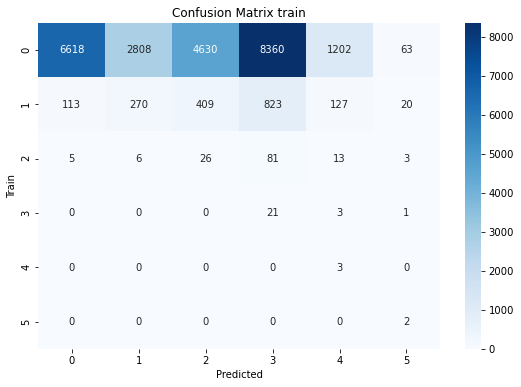

In [204]:
# Representación gráfica de la matriz de confusión sobre el conjunto train.
confusion_matrix_table = pd.crosstab(y_train_2, train_preds_NB2, rownames=['Train'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="Blues", fmt='g')
plt.title("Confusion Matrix train")
plt.savefig('graph/matriz_confusion_NB2train_2.jpg')
plt.show()

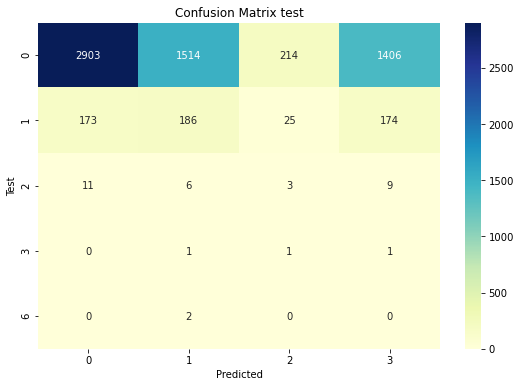

In [205]:
# Representación gráfica de la matriz de confusión sobre el conjunto test.
confusion_matrix_table = pd.crosstab(y_test_2, test_preds_NB2, rownames=['Test'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="YlGnBu", fmt='g')
plt.title("Confusion Matrix test")
plt.savefig('graph/matriz_confusion_NB2test_2.jpg')
plt.show()

In [206]:
y_predict = pd.read_excel('data/y_predictsvm.xls')
test_preds_NB2 = test_preds_NB2.astype(int)
y_predict['test_preds_NB2'] = test_preds_NB2
y_predict.to_excel('data/y_predictsvm.xls')

#### 3.4.1.2 Modelo Gausiano, sólo para días de apertura.   
Se entrena el modelo para el conjunto de sólo los días de apertura, y variable _udsVenta_ categorizada.

In [41]:
# Implementación clasificador Gaussian Naïve Bayes
model_bayes = GaussianNB()
model_bayes.fit(x_train2, y_train2_2)

GaussianNB()

In [42]:
# Precisión sobre train y test
score_train = model_bayes.score(x_train2, y_train2_2)
print('El grado de precisión del modelo para el conjunto train es {}.'.format(round(score_train,4)))
score_test = model_bayes.score(x_test2, y_test2_2)
print('El grado de precisión del modelo para el conjunto test es {}.'.format(round(score_test,4)))

El grado de precisión del modelo para el conjunto train es 0.3507.
El grado de precisión del modelo para el conjunto test es 0.5541.


In [43]:
# Predicción del modelo
train_preds_NB = model_bayes.predict(x_train2)
test_preds_NB = model_bayes.predict(x_test2)

#Vemos el error del algoritmo a la hora de predecir, para comprobar si a ajustado bien.
print('MAE in train:', mean_absolute_error(train_preds_NB, y_train2_2))
print('RMSE in train:', np.sqrt(mean_squared_error(train_preds_NB, y_train2_2)))
print('MAE in test:', mean_absolute_error(test_preds_NB, y_test2_2))
print('RMSE in test:', np.sqrt(mean_squared_error(test_preds_NB, y_test2_2)))

MAE in train: 1.7079834793264648
RMSE in train: 2.2257024040501747
MAE in test: 0.9216727514105543
RMSE in test: 1.5220472875601467


In [44]:
# Precisión, recall y f1 del modelo en conjunto train y test

accuracy_train = accuracy_score(y_train2_2, train_preds_NB, normalize = True)
accuracy_test = accuracy_score(y_test2_2, test_preds_NB, normalize = True)
print('Accuracy train: {}, Accuracy test: {}'.format(round(accuracy_train, 4), round(accuracy_test, 4)))

recall_train = recall_score(y_train2_2, train_preds_NB, average= 'weighted')
recall_test = recall_score(y_test2_2, test_preds_NB, average= 'weighted')
print('Recall train: {}, Recall test: {}'.format(round(recall_train, 4), round(recall_test, 4)))

f1_train = f1_score(y_train2_2, train_preds_NB, average= 'weighted')
f1_test = f1_score(y_test2_2, test_preds_NB, average= 'weighted')
print('F1 train: {}, F1 test: {}'.format(round(f1_train, 4), round(f1_test, 4)))

Accuracy train: 0.3507, Accuracy test: 0.5541
Recall train: 0.3507, Recall test: 0.5541
F1 train: 0.4987, F1 test: 0.6654


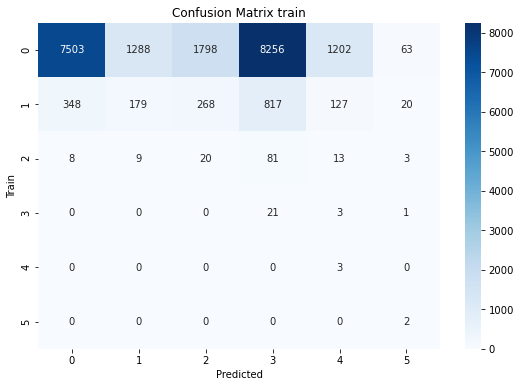

In [45]:
# Representación gráfica de la matriz de confusión sobre el conjunto train.
confusion_matrix_table = pd.crosstab(y_train2_2, train_preds, rownames=['Train'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="Blues", fmt='g')
plt.title("Confusion Matrix train")
plt.savefig('graph/matriz_confusion_NBtrain2_2.jpg')
plt.show()

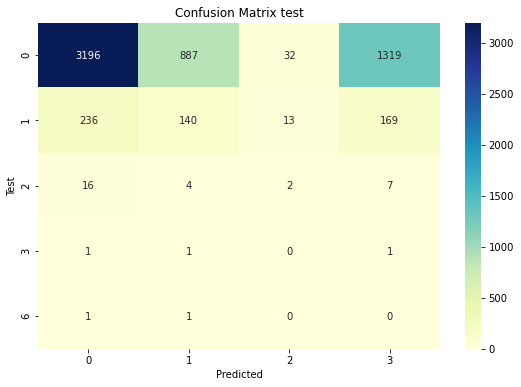

In [46]:
# Representación gráfica de la matriz de confusión sobre el conjunto test.
confusion_matrix_table = pd.crosstab(y_test2_2, test_preds, rownames=['Test'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="YlGnBu", fmt='g')
plt.title("Confusion Matrix test")
plt.savefig('graph/matriz_confusion_NBtest2_2.jpg')
plt.show()

#### 3.4.2 Modelo SVM
Se aborda en este apartado el algoritmo SVM, para las siguientes configuraciones;    

  - Variable _udsVenta_ como variable cuantitativa.
  - Discretiza en 7 intervalos de igual tamaño (fichero sufijo 2).
  - Discretiza en 25 clases que corresponde a los valores de sku (fichero sufijo 3).
  - Discretiva en 14 intervalos de igual tamaño (fichero sufijo 4).

##### 3.4.2.1 Configuración de parámetros de modelo SVM para valor determinado de sku.
Se busca la mejor configuración de parámetros para el modelo SVM, especialmente el kernel óptimo (lineal, logarítmico o polinomial). Aplicar GridSearchCV a todo el fichero pero demora mucho tiempo. Se decide configurar para una partición del fichero, para valor aleatorio de sku. 

In [47]:
df = venta[venta['sku']==23]

# Separación de los conjuntos train y test
dft = df.loc[df['fecha']<= 20211021]
dfs = df.loc[df['fecha']> 20211021]

y_train_4_sku = dft['udsVenta_cat2']
x_train_sku = dft.drop(columns = ['udsVenta', 'udsVentalog', 'udsVenta_cat', 'udsVenta_cat2', 
                                  'fecha', 'udsVenta_clas'], axis = 1)

y_test_4_sku = dfs['udsVenta_cat2']
x_test_sku = dfs.drop(columns = ['udsVenta', 'udsVentalog', 'udsVenta_cat', 'udsVenta_cat2', 
                                 'fecha', 'udsVenta_clas'], axis = 1)

In [48]:
# Definición de los conjuntos parámetro
kernel = ['linear', 'poly', 'rbf']
C = [2, 5, 10, 15]
cache_size = [100, 300, 500, 800]

grid_tree = dict(kernel=kernel, C=C, cache_size=cache_size)
cv =  StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

# Optimizar
SVM_optimizer = GridSearchCV(estimator=SVC(),
                             param_grid=grid_tree,
                             n_jobs=-1,
                             scoring='accuracy',
                             refit = True,
                             cv=cv,
                             error_score=0)

In [49]:
grid_SVM_optimizer = SVM_optimizer.fit(x_train_sku, y_train_4_sku)

C:\Users\jh100\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [50]:
# Obtener la mejor combinación del clasificador SVM
print ('La mejor configuración de parámetros que maximiza la precisión es {}.'.format(grid_SVM_optimizer.best_params_))
print ('Clases de clasificación del modelo {}.'.format(grid_SVM_optimizer.classes_))

# Obtenemos la precisión del modelo
print('Precisión del modelo para el conjunto train {}.'.
      format(round(grid_SVM_optimizer.score(x_train_sku, y_train_4_sku),4)))
print('Precisión del modelo para el conjunto test {}.'.
      format(round(grid_SVM_optimizer.score(x_test_sku, y_test_4_sku),4)))

La mejor configuración de parámetros que maximiza la precisión es {'C': 2, 'cache_size': 100, 'kernel': 'poly'}.
Clases de clasificación del modelo [0 1 2 3].
Precisión del modelo para el conjunto train 0.7893.
Precisión del modelo para el conjunto test 0.6269.


Se entrena ahora el modelo para el fichero con fechas de apertura bolOpen=1 y se comparan las precisiones en ambos modelos.

In [51]:
df = venta2[venta2['sku']==23]

# Separación de los conjuntos train y test
dft = df.loc[df['fecha']<= 20211021]
dfs = df.loc[df['fecha']> 20211021]

y_train2_4_sku = dft['udsVenta_cat2']
x_train2_sku = dft.drop(columns = ['udsVenta', 'udsVentalog', 'udsVenta_cat', 'udsVenta_cat2', 
                                  'fecha', 'udsVenta_clas'], axis = 1)

y_test2_4_sku = dfs['udsVenta_cat2']
x_test2_sku = dfs.drop(columns = ['udsVenta', 'udsVentalog', 'udsVenta_cat', 'udsVenta_cat2', 
                                 'fecha', 'udsVenta_clas'], axis = 1)

In [52]:
grid2_SVM_optimizer = SVM_optimizer.fit(x_train2_sku, y_train2_4_sku)

C:\Users\jh100\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [53]:
# Obtener la mejor combinación del clasificador SVM
print ('La mejor configuración de parámetros que maximiza la precisión es {}.'.format(grid2_SVM_optimizer.best_params_))
print ('Clases de clasificación del modelo {}.'.format(grid2_SVM_optimizer.classes_))

# Obtenemos la precisión del modelo
print('Precisión del modelo para el conjunto train {}.'.
      format(round(grid2_SVM_optimizer.score(x_train2_sku, y_train2_4_sku),4)))
print('Precisión del modelo para el conjunto test {}.'.
      format(round(grid2_SVM_optimizer.score(x_test2_sku, y_test2_4_sku),4)))

La mejor configuración de parámetros que maximiza la precisión es {'C': 2, 'cache_size': 100, 'kernel': 'poly'}.
Clases de clasificación del modelo [0 1 2 3].
Precisión del modelo para el conjunto train 0.7613.
Precisión del modelo para el conjutno test 0.6212.


Se ha comparado la precisión para el fichero de todas las fechas, con el de sólo días establecimiento está abierto. Se obtiene mayor precision con el fichero de todas las fechas. Entre todos los parámetros posible, el que maximiza la precisión es C=2, kernel='poly' y cache_size=100.  
Se entrena el algoritmo para las cuatro configuraciones antes descritas.

##### 3.4.2.2 Modelo SVR para variable cuantitativa.  
Se entrena modelo SVM con la variable objetivo _udsVenta_ como variable cuantitativa. 

In [54]:
# Modelo clasificación para variable dependiente continua
# SVR (versión del modelo SVM)
# Hiperplano lineal

svr = SVR(kernel='poly', C=2, cache_size=100)

# Entrenamiento
svr.fit(x_train, y_train_class)

# Predicción del modelo
train_preds_1 = svr.predict(x_train)
test_preds_1 = svr.predict(x_test)

#Vemos el error del algoritmo a la hora de predecir, para comprobar si a ajustado bien.
print('MAE in train:', mean_absolute_error(train_preds_1, y_train_class))
print('RMSE in train:', np.sqrt(mean_squared_error(train_preds_1, y_train_class)))
print('MAE in test:', mean_absolute_error(test_preds_1, y_test_class))
print('RMSE in test:', np.sqrt(mean_squared_error(test_preds_1, y_test_class)))

MAE in train: 1.5954841903324533
RMSE in train: 2.3682287133355433
MAE in test: 1.7365111550938452
RMSE in test: 2.4957980874179486


In [55]:
# Precisión sobre train y test
score_train = svr.score(x_train, y_train_class)
print('El grado de precisión del modelo para el conjunto train es {}.'.format(round(score_train,4)))
score_test = svr.score(x_test, y_test_class)
print('El grado de precisión del modelo para el conjunto test es {}.'.format(round(score_test,4)))

El grado de precisión del modelo para el conjunto train es -0.0199.
El grado de precisión del modelo para el conjunto test es -0.127.


In [57]:
# Categorizar variable predicción para cálculo de los parámetros del modelo.

label_encoder = LabelEncoder()

train_preds_class = label_encoder.fit_transform(train_preds_1)
test_preds_class = label_encoder.fit_transform(test_preds_1)

In [58]:
# Precisión, recall y f1 del modelo en conjunto train y test

accuracy_train = accuracy_score(y_train_class, train_preds_class, normalize = True)
accuracy_test = accuracy_score(y_test_class, test_preds_class, normalize = True)
print('Accuracy train: {}, Accuracy test: {}'.format(round(accuracy_train, 4), round(accuracy_test, 4)))

recall_train = recall_score(y_train_class, train_preds_class, average= 'weighted')
recall_test = recall_score(y_test_class, test_preds_class, average= 'weighted')
print('Recall train: {}, Recall test: {}'.format(round(recall_train, 4), round(recall_test, 4)))

f1_train = f1_score(y_train_class, train_preds_class, average= 'weighted')
f1_test = f1_score(y_test_class, test_preds_class, average= 'weighted')
print('F1 train: {}, F1 test: {}'.format(round(f1_train, 4), round(f1_test, 4)))

Accuracy train: 0.0, Accuracy test: 0.0002
Recall train: 0.0, Recall test: 0.0002
F1 train: 0.0001, F1 test: 0.0003


C:\Users\jh100\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jh100\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


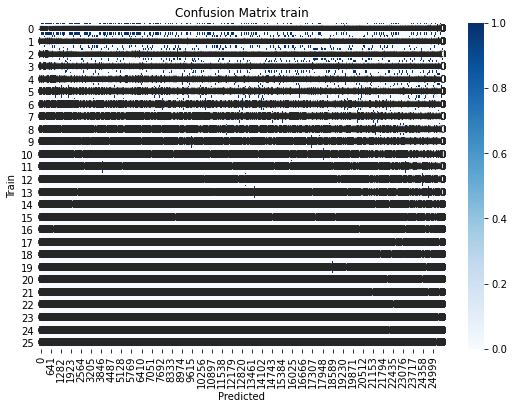

In [59]:
# Representación gráfica de la matriz de confusión sobre el conjunto train.
confusion_matrix_table = pd.crosstab(y_train_class, train_preds_class, rownames=['Train'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="Blues", fmt='g')
plt.title("Confusion Matrix train")
plt.savefig('graph/matriz_confusion_SVCpolytrain_1.jpg')
plt.show()

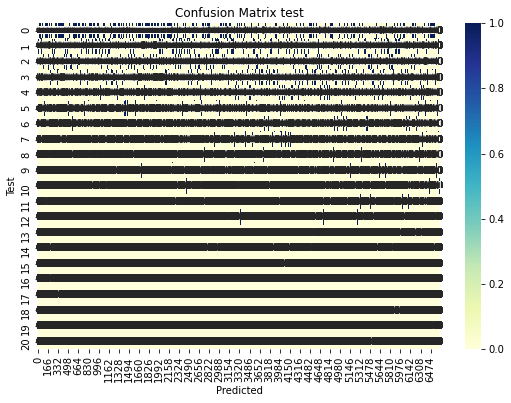

In [60]:
# Representación gráfica de la matriz de confusión sobre el conjunto test.
confusion_matrix_table = pd.crosstab(y_test_class, test_preds_class, rownames=['Test'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="YlGnBu", fmt='g')
plt.title("Confusion Matrix test")
plt.savefig('graph/matriz_confusion_SVCpolytest_1.jpg')
plt.show()

#### 3.4.2.3 Modelo SVM para variable _udsVenta_ categorizada por intervalos de igual tamaño.  
Se aborda en este apartado el algoritmo SVM donde la variable objetivo _udsVenta_ se ha categorizado según intervalos de igual longitud. El rango de valores [0, 196] se ha separado en 7, 14 y 25 intervalos.  

##### 3.4.2.3.1 Variable udsVenta discretizada en 7 intervalos de igual tamaño.

In [61]:
# Modelo clasificación para variable dependiente discreta
# SVC (versión del modelo SVM)
# Variable udsVenta categorizada en 7 clases

svm = SVC(kernel='poly', C=2, cache_size=100)

# Entrenamiento
svm.fit(x_train, y_train_2)

# Predicción del modelo
train_preds_2 = svm.predict(x_train)
test_preds_2 = svm.predict(x_test)

#Vemos el error del algoritmo a la hora de predecir, para comprobar si a ajustado bien.
print('MAE in train:', mean_absolute_error(train_preds_2, y_train_2))
print('RMSE in train:', np.sqrt(mean_squared_error(train_preds_2, y_train_2)))
print('MAE in test:', mean_absolute_error(test_preds_2, y_test_2))
print('RMSE in test:', np.sqrt(mean_squared_error(test_preds_2, y_test_2)))

MAE in train: 0.08306322489944155
RMSE in train: 0.31992940604542647
MAE in test: 0.09609292502639916
RMSE in test: 0.34148036538825066


In [62]:
# Precisión sobre train y test
score_train = svm.score(x_train, y_train_2)
print('El grado de precisión del modelo para el conjunto train es {}.'.format(round(score_train,4)))
score_test = svm.score(x_test, y_test_2)
print('El grado de precisión del modelo para el conjunto test es {}.'.format(round(score_test,4)))

El grado de precisión del modelo para el conjunto train es 0.9248.
El grado de precisión del modelo para el conjunto test es 0.9107.


In [64]:
# Precisión, recall y f1 del modelo en conjunto train y test

accuracy_train = accuracy_score(y_train_2, train_preds_2, normalize = True)
accuracy_test = accuracy_score(y_test_2, test_preds_2, normalize = True)
print('Accuracy train: {}, Accuracy test: {}'.format(round(accuracy_train, 4), round(accuracy_test, 4)))

recall_train = recall_score(y_train_2, train_preds_2, average= 'weighted')
recall_test = recall_score(y_test_2, test_preds_2, average= 'weighted')
print('Recall train: {}, Recall test: {}'.format(round(recall_train, 4), round(recall_test, 4)))

f1_train = f1_score(y_train_2, train_preds_2, average= 'weighted')
f1_test = f1_score(y_test_2, test_preds_2, average= 'weighted')
print('F1 train: {}, F1 test: {}'.format(round(f1_train, 4), round(f1_test, 4)))

Accuracy train: 0.9248, Accuracy test: 0.9107
Recall train: 0.9248, Recall test: 0.9107
F1 train: 0.8886, F1 test: 0.8681


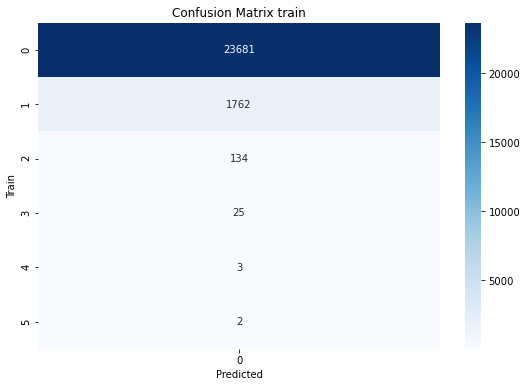

In [65]:
# Representación gráfica de la matriz de confusión sobre el conjunto train.
confusion_matrix_table = pd.crosstab(y_train_2, train_preds_2, rownames=['Train'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="Blues", fmt='g')
plt.title("Confusion Matrix train")
plt.savefig('graph/matriz_confusion_SVCpolytrain_2.jpg')
plt.show()

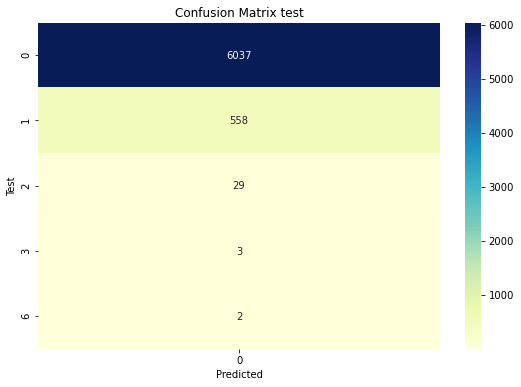

In [66]:
# Representación gráfica de la matriz de confusión sobre el conjunto test.
confusion_matrix_table = pd.crosstab(y_test_2, test_preds_2, rownames=['Test'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="YlGnBu", fmt='g')
plt.title("Confusion Matrix test")
plt.savefig('graph/matriz_confusion_SVCpolytest_2.jpg')
plt.show()

#### 3.4.2.3.2 Variable udsVenta discretizada en 14 intervalos de igual tamaño.   
Se entrena en este ejemplo, la variable _udsVenta_ discretizada en 14 intervalos de igual tamaño.  

In [67]:
svm2 = SVC(kernel='poly', C=2, cache_size=100)

# Entrenamiento
svm2.fit(x_train, y_train_4)

# Predicción del modelo
train_preds_4 = svm2.predict(x_train)
test_preds_4 = svm2.predict(x_test)

#Vemos el error del algoritmo a la hora de predecir, para comprobar si a ajustado bien.
print('MAE in train:', mean_absolute_error(train_preds_4, y_train_4))
print('RMSE in train:', np.sqrt(mean_squared_error(train_preds_4, y_train_4)))
print('MAE in test:', mean_absolute_error(test_preds_4, y_test_4))
print('RMSE in test:', np.sqrt(mean_squared_error(test_preds_4, y_test_4)))

MAE in train: 0.4102393876674347
RMSE in train: 0.8527966209922982
MAE in test: 0.4843867853371549
RMSE in test: 0.9172259067463356


In [68]:
# Precisión sobre train y test
score_train = svm2.score(x_train, y_train_4)
print('El grado de precisión del modelo para el conjunto train es {}.'.format(round(score_train,4)))
score_test = svm2.score(x_test, y_test_4)
print('El grado de precisión del modelo para el conjunto test es {}.'.format(round(score_test,4)))

El grado de precisión del modelo para el conjunto train es 0.6965.
El grado de precisión del modelo para el conjunto test es 0.6367.


In [70]:
# Precisión, recall y f1 del modelo en conjunto train y test

accuracy_train = accuracy_score(y_train_4, train_preds_4, normalize = True)
accuracy_test = accuracy_score(y_test_4, test_preds_4, normalize = True)
print('Accuracy train: {}, Accuracy test: {}'.format(round(accuracy_train, 4), round(accuracy_test, 4)))

recall_train = recall_score(y_train_4, train_preds_4, average= 'weighted')
recall_test = recall_score(y_test_4, test_preds_4, average= 'weighted')
print('Recall train: {}, Recall test: {}'.format(round(recall_train, 4), round(recall_test, 4)))

f1_train = f1_score(y_train_4, train_preds_4, average= 'weighted')
f1_test = f1_score(y_test_4, test_preds_4, average= 'weighted')
print('F1 train: {}, F1 test: {}'.format(round(f1_train, 4), round(f1_test, 4)))

Accuracy train: 0.6965, Accuracy test: 0.6367
Recall train: 0.6965, Recall test: 0.6367
F1 train: 0.5719, F1 test: 0.4954


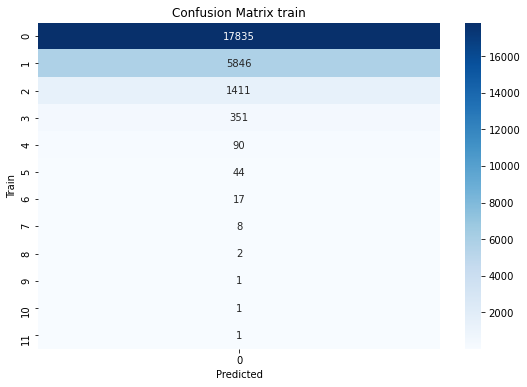

In [71]:
# Representación gráfica de la matriz de confusión sobre el conjunto train.
confusion_matrix_table = pd.crosstab(y_train_4, train_preds_4, rownames=['Train'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="Blues", fmt='g')
plt.title("Confusion Matrix train")
plt.savefig('graph/matriz_confusion_SVCpolytrain_2.jpg')
plt.show()

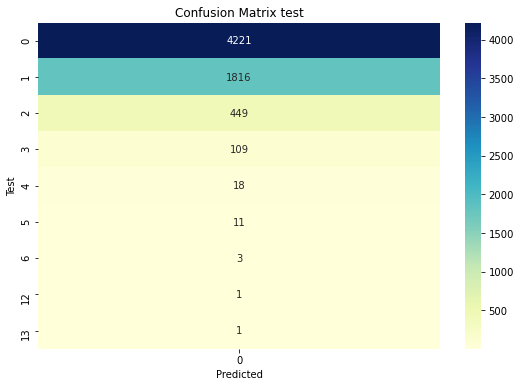

In [72]:
# Representación gráfica de la matriz de confusión sobre el conjunto test.
confusion_matrix_table = pd.crosstab(y_test_4, test_preds_4, rownames=['Test'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="YlGnBu", fmt='g')
plt.title("Confusion Matrix test")
plt.savefig('graph/matriz_confusion_SVCpolytest_2.jpg')
plt.show()

##### 3.4.2.3.3 Variable udsVenta discretizada en 25 clases, según valores únicos.  
En este apartado se aborda algoritmo SVM con la variable _udsVenta_ discretazada en 25 clases, según posibles valores únicos. 

In [73]:
svm3 = SVC(kernel='poly', C=2, cache_size=100)

# Entrenamiento
svm3.fit(x_train, y_train_3)

# Predicción del modelo
train_preds_3 = svm3.predict(x_train)
test_preds_3 = svm3.predict(x_test)

#Vemos el error del algoritmo a la hora de predecir, para comprobar si a ajustado bien.
print('MAE in train:', mean_absolute_error(train_preds_3, y_train_3))
print('RMSE in train:', np.sqrt(mean_squared_error(train_preds_3, y_train_3)))
print('MAE in test:', mean_absolute_error(test_preds_3, y_test_3))
print('RMSE in test:', np.sqrt(mean_squared_error(test_preds_3, y_test_3)))

MAE in train: 1.9352130276877417
RMSE in train: 3.0404582385918286
MAE in test: 2.1973148287826216
RMSE in test: 3.231547987969824


In [74]:
# Precisión sobre train y test
score_train = svm3.score(x_train, y_train_3)
print('El grado de precisión del modelo para el conjunto train es {}.'.format(round(score_train,4)))
score_test = svm3.score(x_test, y_test_3)
print('El grado de precisión del modelo para el conjunto test es {}.'.format(round(score_test,4)))

El grado de precisión del modelo para el conjunto train es 0.3562.
El grado de precisión del modelo para el conjunto test es 0.2978.


In [75]:
# Precisión, recall y f1 del modelo en conjunto train y test

accuracy_train = accuracy_score(y_train_3, train_preds_3, normalize = True)
accuracy_test = accuracy_score(y_test_3, test_preds_3, normalize = True)
print('Accuracy train: {}, Accuracy test: {}'.format(round(accuracy_train, 4), round(accuracy_test, 4)))

recall_train = recall_score(y_train_3, train_preds_3, average= 'weighted')
recall_test = recall_score(y_test_3, test_preds_3, average= 'weighted')
print('Recall train: {}, Recall test: {}'.format(round(recall_train, 4), round(recall_test, 4)))

f1_train = f1_score(y_train_3, train_preds_3, average= 'weighted')
f1_test = f1_score(y_test_3, test_preds_3, average= 'weighted')
print('F1 train: {}, F1 test: {}'.format(round(f1_train, 4), round(f1_test, 4)))

Accuracy train: 0.3562, Accuracy test: 0.2978
Recall train: 0.3562, Recall test: 0.2978
F1 train: 0.1871, F1 test: 0.1367


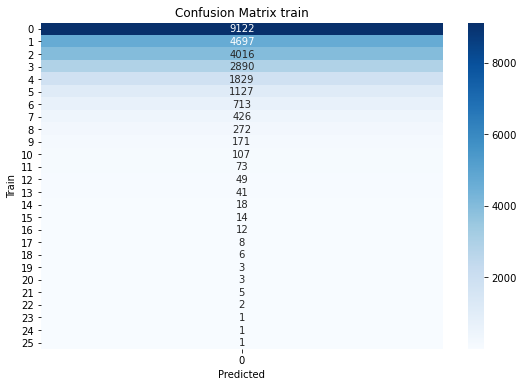

In [76]:
# Representación gráfica de la matriz de confusión sobre el conjunto train.
confusion_matrix_table = pd.crosstab(y_train_3, train_preds_3, rownames=['Train'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="Blues", fmt='g')
plt.title("Confusion Matrix train")
plt.savefig('graph/matriz_confusion_SVCpolytrain_3.jpg')
plt.show()

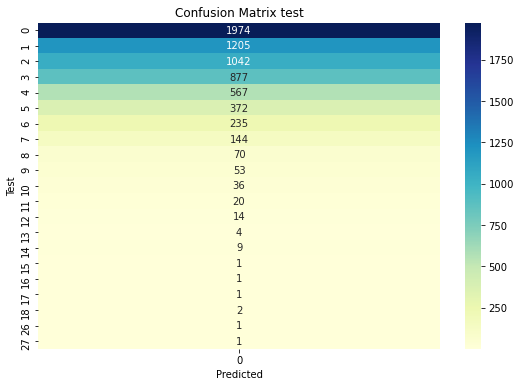

In [77]:
# Representación gráfica de la matriz de confusión sobre el conjunto test.
confusion_matrix_table = pd.crosstab(y_test_3, test_preds_3, rownames=['Test'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="YlGnBu", fmt='g')
plt.title("Confusion Matrix test")
plt.savefig('graph/matriz_confusion_SVCpolytest_3.jpg')
plt.show()

Se guardan las predicciones en fichero

In [ ]:
# Predicciones de los diferentes modelos para el conjunto test.

test_preds_NB = test_preds_NB.astype(int)
test_preds_NB2 = test_preds_NB2.astype(int)
test_preds_SVM4 = test_preds_4.astype(int)
test_preds_SVM3 = test_preds_3.astype(int)
test_preds_SVM2 = test_preds_2.astype(int)
test_preds_SVM1 = test_preds_class.astype(int)

# Unión de todas las predicciones en un único fichero.
y_predict =  np.column_stack((test_preds_NB, test_preds_NB2, test_preds_SVM4,
                              test_preds_SVM3, test_preds_SVM2, test_preds_SVM1))

# Transformación en dataframe
y_predict = pd.DataFrame(y_predict, columns=['test_preds_NB', 'test_preds_NB2', 'test_preds_SVM4',
                                             'test_preds_SVM3','test_preds_SVM2','test_preds_SVM1'])

In [79]:
y_predict.to_excel('data/y_predictsvm.xls')

##### 3.4.2.4 Algoritmo SVC para variable categórica en días de venta.  
La variable dependiente _udsVenta_ tiene un elevado sesgo a la derecha, concentrando el 33% de las observaciones en el valor _udsVenta = 0_. Esto motiva que el modelo no sea eficaz en la predicción, asignando a la mayoría de las predicciones este valor. Se prueba de nuevo el algoritmo, pero prescindiendo de las observaciones en las que el establecimiento está cerrado (_bolOpen = 0), en las que el 100% de _udsVenta = 0_.  Se han eliminado 4.177 observaciones y _udsVenta = 0_ representa ahora el 23,35% de las observaciones.   
Se ha suavizado el sesgo en la distribución de frecuencias.  
La variable _udsVenta_ se ha categorizado por su valor, definiéndose un total de 25 clases.  

In [ ]:
# Modelo clasificación para variable dependiente discreta en días abiertos
# SVC (versión del modelo SVM)
# Hiperplano lineal

svm = SVC(kernel='poly', C=2)

# Entrenamiento
svm.fit(x_train2, y_train2_3)

# Predicción del modelo
train_preds_5 = svm.predict(x_train2)
test_preds_5 = svm.predict(x_test2)

#Vemos el error del algoritmo a la hora de predecir, para comprobar si a ajustado bien.
print('MAE in train:', mean_absolute_error(train_preds_5, y_train2_3))
print('RMSE in train:', np.sqrt(mean_squared_error(train_preds_5, y_train2_3)))
print('MAE in test:', mean_absolute_error(test_preds_5, y_test2_3))
print('RMSE in test:', np.sqrt(mean_squared_error(test_preds_5, y_test2_3)))

In [ ]:
# Precisión, recall y f1 del modelo en conjunto train y test

accuracy_train = accuracy_score(y_train2_3, train_preds_5, normalize = True)
accuracy_test = accuracy_score(y_test2_3, test_preds_5, normalize = True)
print('Accuracy train: {}, Accuracy test: {}'.format(round(accuracy_train, 4), round(accuracy_test, 4)))

recall_train = recall_score(y_train2_3, train_preds_5, average= 'weighted')
recall_test = recall_score(y_test2_3, test_preds_5, average= 'weighted')
print('Recall train: {}, Recall test: {}'.format(round(recall_train, 4), round(recall_test, 4)))

f1_train = f1_score(y_train2_3, train_preds_5, average= 'weighted')
f1_test = f1_score(y_test2_3, test_preds_5, average= 'weighted')
print('F1 train: {}, F1 test: {}'.format(round(f1_train, 4), round(f1_test, 4)))

In [ ]:
# Matriz de confusión
# confusion_matrix(y_test2_3, test_preds_5)

In [ ]:
# Representación gráfica de la matriz de confusión sobre el conjunto train.
confusion_matrix_table = pd.crosstab(y_train2_3, train_preds, rownames=['Train'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="Blues", fmt='g')
plt.title("Confusion Matrix train")
plt.savefig('graph/matriz_confusion_SVCtrain2_3.jpg')
plt.show()

In [ ]:
# Representación gráfica de la matriz de confusión sobre el conjunto test.
confusion_matrix_table = pd.crosstab(y_test2_3, test_preds, rownames=['Test'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="YlGnBu", fmt='g')
plt.title("Confusion Matrix test")
plt.savefig('graph/matriz_confusion_SVCtest2_3.jpg')
plt.show()

In [ ]:
y_predict = pd.read_excel('data/y_predictsvm.xls')
test_preds_SVM5 = test_preds_5.astype(int)
y_predict['test_preds_Tree_4'] = test_preds_SVM5
y_predict.to_excel('data/y_predictsvm.xls')

### 3.4.3 Modelo Arbol de decisión  
Arbol de decisión es otro algoritmo de ML para clasificación. Se prueba en este apartado la precisión del algoritmo aplicado a diferentes discretizaciones de la variable udsVenta.  

#### 3.4.3.1 Árbol de decisión variable _udsVenta_ categorizada.   
Se aplica algoritmo para fichero completo con la variable _udsVenta_ categorizada por clases.

In [38]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_class = label_encoder.fit_transform(y_train_1)
y_test_class = label_encoder.fit_transform(y_test_1)

In [39]:
y_train_class.shape

(25607,)

In [40]:
# Se define el modelo Decision Tree simple
model_tree = DecisionTreeClassifier(max_depth=5, min_samples_split=2)

# Entrena el modelo para el conjunto train reducido a 2 dimensiones
model_tree.fit(x_train, y_train_class)

DecisionTreeClassifier(max_depth=5)

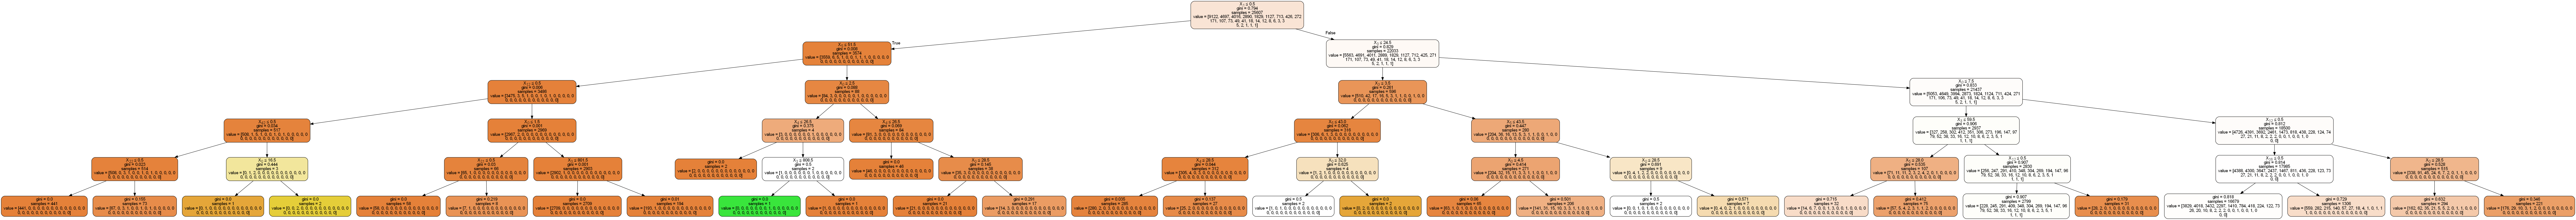

In [41]:
# Representación del árbol de decisión.
dot_data = StringIO()
export_graphviz(model_tree, out_file = dot_data,
                filled = True, rounded = True,
                special_characters = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [42]:
# Precisión sobre train y test
score_train = model_tree.score(x_train, y_train_class)
print('El grado de precisión del modelo para el conjunto train es {}.'.format(round(score_train,4)))
score_test = model_tree.score(x_test, y_test_class)
print('El grado de precisión del modelo para el conjunto test es {}.'.format(round(score_test,4)))

# Matriz de confusión sobre train
y_predict_train_6 = model_tree.predict(x_train)
y_predict_test_6 = model_tree.predict(x_test)

El grado de precisión del modelo para el conjunto train es 0.3711.
El grado de precisión del modelo para el conjunto test es 0.3326.


In [43]:
#Vemos el error del algoritmo a la hora de predecir, para comprobar si a ajustado bien.
print('MAE in train:', mean_absolute_error(y_predict_train_6, y_train_class))
print('RMSE in train:', np.sqrt(mean_squared_error(y_predict_train_6, y_train_class)))
print('MAE in test:', mean_absolute_error(y_predict_test_6, y_test_class))
print('RMSE in test:', np.sqrt(mean_squared_error(y_predict_test_6, y_test_class)))

MAE in train: 1.3684539383762253
RMSE in train: 2.259738085335643
MAE in test: 1.5518177704027756
RMSE in test: 2.432835917586868


<module 'matplotlib.pyplot' from 'C:\\Users\\jh100\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

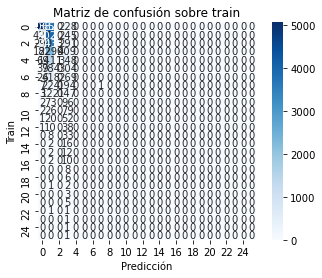

In [44]:
matrix_train = confusion_matrix(y_train_class, y_predict_train_6)
sns.heatmap(matrix_train, annot=True, fmt="d", cmap='Blues', square=True)
plt.xlabel("Predicción")
plt.ylabel("Train")
plt.title('Matriz de confusión sobre train')
# plt.savefig('graph/matriz confusion arbol decision.jpg')
plt

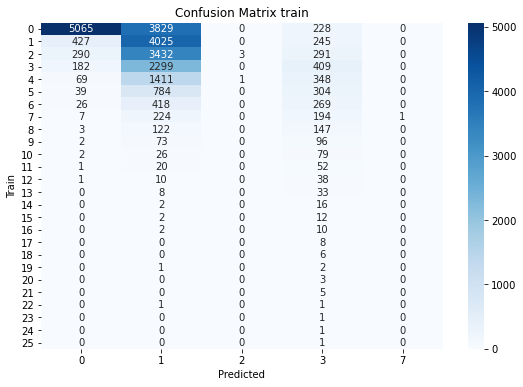

In [45]:
# Representación gráfica de la matriz de confusión sobre el conjunto train.
confusion_matrix_table = pd.crosstab(y_train_class, y_predict_train_6, rownames=['Train'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="Blues", fmt='g')
plt.title("Confusion Matrix train")
plt.savefig('graph/matriz_confusion_DECISONTREEtrain_class.jpg')
plt.show()

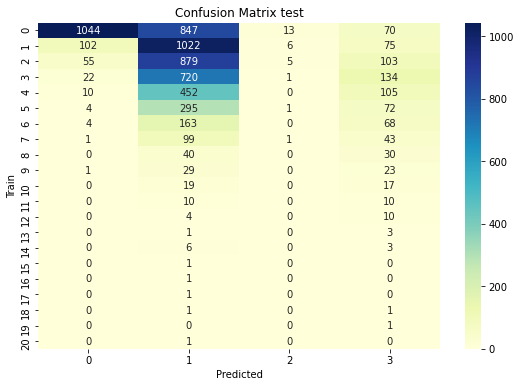

In [46]:
# Representación gráfica de la matriz de confusión sobre el conjunto test.
confusion_matrix_table = pd.crosstab(y_test_class, y_predict_test_6, rownames=['Train'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="YlGnBu", fmt='g')
plt.title("Confusion Matrix test")
plt.savefig('graph/matriz_confusion_DECISONTREEtest_class.jpg')
plt.show()

In [47]:
y_predict = pd.read_excel('data/y_predictsvm.xls')
test_preds_Tree_class = y_predict_test_6.astype(int)
y_predict['test_preds_Tree_4'] = test_preds_Tree_class
y_predict.to_excel('data/y_predictsvm.xls')

#### 3.4.3.2 Árbol decisión variable _udsVenta_ categorizada en 7 intervalos de igual tamaño.   
Previo al algoritmo, se obtienen mejores parámetros para configuración del modelo.

In [48]:
# Definición de los conjuntos parámetro
max_depth = [4, 5, 6, 7, 8, 9, 10]
min_samples_split = [2, 10, 20, 50, 100]

grid_tree = dict(max_depth=max_depth, min_samples_split=min_samples_split)
cv =  StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

# Optimizar
tree_optimizer = GridSearchCV(estimator=DecisionTreeClassifier(),
                             param_grid=grid_tree,
                             n_jobs=-1,
                             scoring='accuracy',
                             refit = True,
                             cv=cv,
                             error_score=0)

grid_tree_optimizer = tree_optimizer.fit(x_train, y_train_2)

# Obtener la mejor combinación del clasificador SVM
print ('La mejor configuración de parámetros que maximiza la precisión es {}.'.format(grid_tree_optimizer.best_params_))
print ('Clases de clasificación del modelo {}.'.format(grid_tree_optimizer.classes_))

# Obtenemos la precisión del modelo
print('Precisión del modelo {}.'.format(round(grid_tree_optimizer.score(x_train, y_train_2),4)))

C:\Users\jh100\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


La mejor configuración de parámetros que maximiza la precisión es {'max_depth': 6, 'min_samples_split': 100}.
Clases de clasificación del modelo [0 1 2 3 4 5].
Precisión del modelo 0.9274.


In [49]:
# Se define el modelo Decision Tree simple para los mejores parámetros
model_tree2 = DecisionTreeClassifier(max_depth=8, min_samples_split=100)

# Entrena el modelo para el conjunto train.
model_tree2.fit(x_train, y_train_2)

DecisionTreeClassifier(max_depth=8, min_samples_split=100)

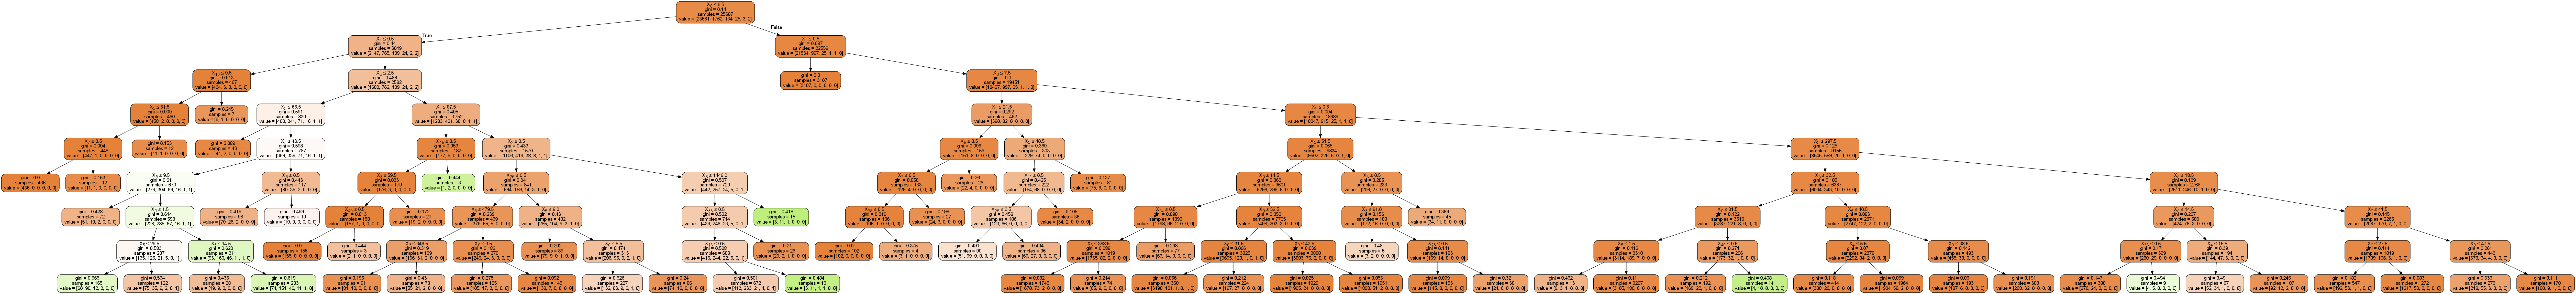

In [50]:
# Representación del árbol de decisión.
dot_data = StringIO()
export_graphviz(model_tree2, out_file = dot_data,
                filled = True, rounded = True,
                special_characters = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [51]:
# Precisión sobre train y test
score_train = model_tree2.score(x_train, y_train_2)
print('El grado de precisión del modelo para el conjunto train es {}.'.format(round(score_train,4)))
score_test = model_tree2.score(x_test, y_test_2)
print('El grado de precisión del modelo para el conjunto test es {}.'.format(round(score_test,4)))

# Predicciones sobre conjunto train y test
y_predict_train_2 = model_tree2.predict(x_train)
y_predict_test_2 = model_tree2.predict(x_test)

El grado de precisión del modelo para el conjunto train es 0.9299.
El grado de precisión del modelo para el conjunto test es 0.903.


In [52]:
#Vemos el error del algoritmo a la hora de predecir, para comprobar si a ajustado bien.
print('MAE in train:', mean_absolute_error(y_predict_train_2, y_train_2))
print('RMSE in train:', np.sqrt(mean_squared_error(y_predict_train_2, y_train_2)))
print('MAE in test:', mean_absolute_error(y_predict_test_2, y_test_2))
print('RMSE in test:', np.sqrt(mean_squared_error(y_predict_test_2, y_test_2)))

MAE in train: 0.07497949779357208
RMSE in train: 0.29497026782026287
MAE in test: 0.10333383617438528
RMSE in test: 0.35063462065258333


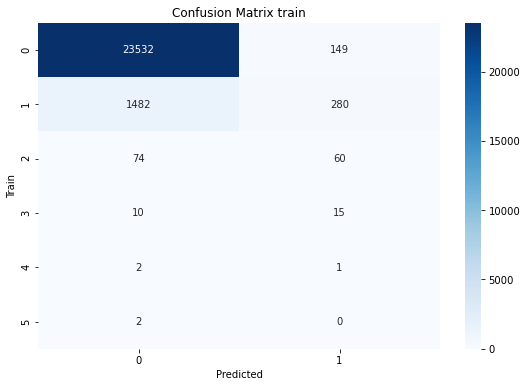

In [53]:
# Representación gráfica de la matriz de confusión sobre el conjunto train.
confusion_matrix_table = pd.crosstab(y_train_2, y_predict_train_2, rownames=['Train'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="Blues", fmt='g')
plt.title("Confusion Matrix train")
plt.savefig('graph/matriz_confusion_DECISONTREEtrain_2.jpg')
plt.show()

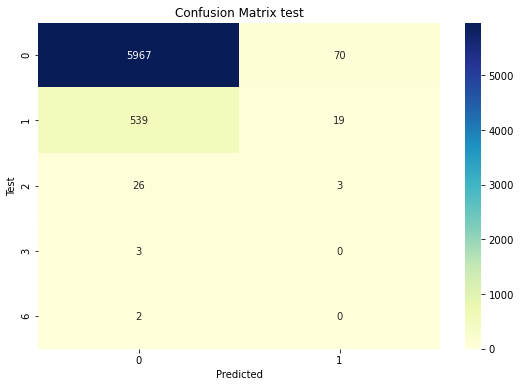

In [54]:
# Representación gráfica de la matriz de confusión sobre el conjunto test.
confusion_matrix_table = pd.crosstab(y_test_2, y_predict_test_2, rownames=['Test'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="YlGnBu", fmt='g')
plt.title("Confusion Matrix test")
plt.savefig('graph/matriz_confusion_DECISONTREEtest_2.jpg')
plt.show()

In [55]:
y_predict = pd.read_excel('data/y_predictsvm.xls')
test_preds_Tree_2 = y_predict_test_2.astype(int)
y_predict['test_preds_Tree_4'] = test_preds_Tree_2
y_predict.to_excel('data/y_predictsvm.xls')

##### 3.4.3.3 Árbol decisión, variable _udsVenta_ categorizada en 25 clases.  
Se aplica algoritmo al modelo con variable udsVenta categorizada por clases. No se aplica filtro para sólo días de apertura.

In [56]:
# Optimizar
tree_optimizer = GridSearchCV(estimator=DecisionTreeClassifier(),
                             param_grid=grid_tree,
                             n_jobs=-1,
                             scoring='accuracy',
                             refit = True,
                             cv=cv,
                             error_score=0)

grid_tree_optimizer = tree_optimizer.fit(x_train, y_train_3)

# Obtener la mejor combinación del clasificador SVM
print ('La mejor configuración de parámetros que maximiza la precisión es {}.'.format(grid_tree_optimizer.best_params_))
print ('Clases de clasificación del modelo {}.'.format(grid_tree_optimizer.classes_))

# Obtenemos la precisión del modelo
print('Precisión del modelo {}.'.format(round(grid_tree_optimizer.score(x_train, y_train_3),4)))

C:\Users\jh100\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


La mejor configuración de parámetros que maximiza la precisión es {'max_depth': 10, 'min_samples_split': 100}.
Clases de clasificación del modelo [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25].
Precisión del modelo 0.3943.


In [57]:
# Se define el modelo Decision Tree simple para los mejores parámetros
model_tree3 = DecisionTreeClassifier(max_depth=8, min_samples_split=100)

# Entrena el modelo para el conjunto train reducido a días abierto
model_tree3.fit(x_train, y_train_3)

DecisionTreeClassifier(max_depth=8, min_samples_split=100)

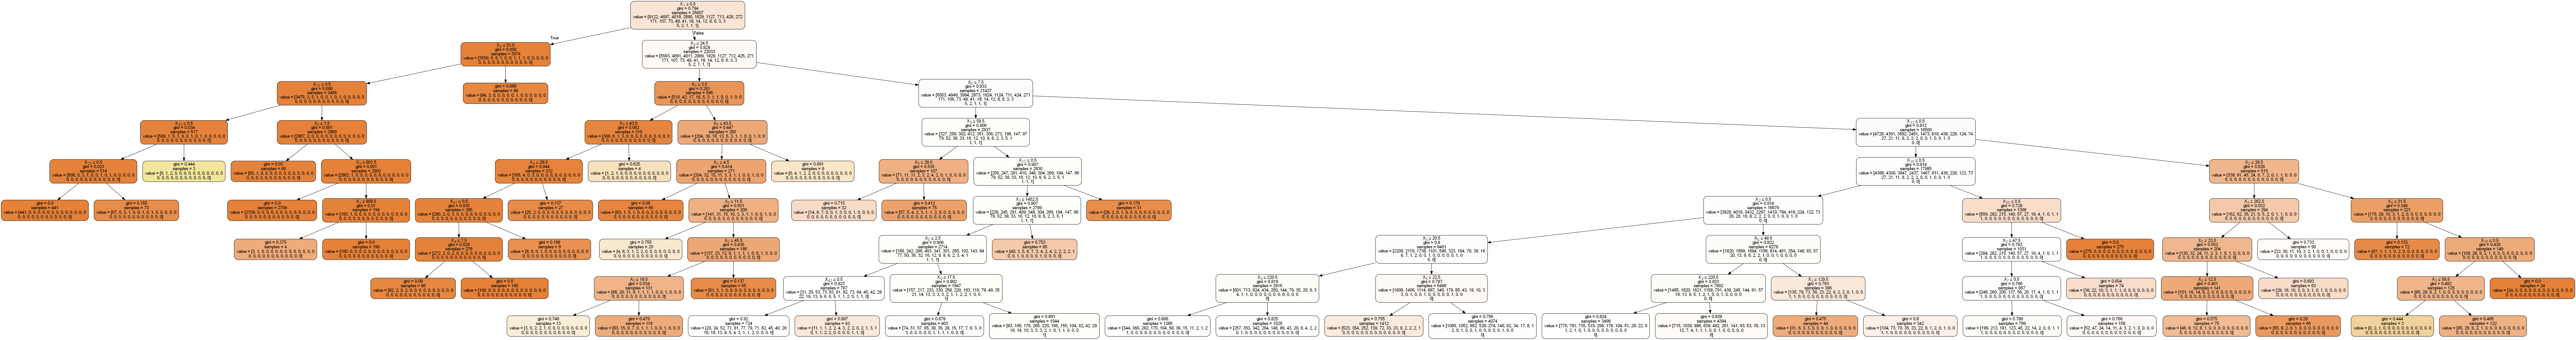

In [58]:
# Representación del árbol de decisión.
dot_data = StringIO()
export_graphviz(model_tree3, out_file = dot_data,
                filled = True, rounded = True,
                special_characters = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [59]:
# Precisión sobre train y test
score_train = model_tree3.score(x_train, y_train_3)
print('El grado de precisión del modelo para el conjunto train es {}.'.format(round(score_train,4)))
score_test = model_tree3.score(x_test, y_test_3)
print('El grado de precisión del modelo para el conjunto test es {}.'.format(round(score_test,4)))

# Predicciones sobre conjunto train y test
y_predict_train_3 = model_tree3.predict(x_train)
y_predict_test_3 = model_tree3.predict(x_test)

El grado de precisión del modelo para el conjunto train es 0.3844.
El grado de precisión del modelo para el conjunto test es 0.305.


In [60]:
c = cross_val_score(model_tree3, x_train, y_train_3, cv=6).mean()
print('La precisión media del modelo aplicado al conjunto train, es:',round(c*100,2),'%')

C:\Users\jh100\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  % (min_groups, self.n_splits)), UserWarning)


La precisión media del modelo aplicado al conjunto train, es: 24.44 %


In [61]:
#Vemos el error del algoritmo a la hora de predecir, para comprobar si a ajustado bien.
print('MAE in train:', mean_absolute_error(y_predict_train_3, y_train_3))
print('RMSE in train:', np.sqrt(mean_squared_error(y_predict_train_3, y_train_3)))
print('MAE in test:', mean_absolute_error(y_predict_test_3, y_test_3))
print('RMSE in test:', np.sqrt(mean_squared_error(y_predict_test_3, y_test_3)))

MAE in train: 1.4494474167219902
RMSE in train: 2.3807194719340137
MAE in test: 1.768441695580027
RMSE in test: 2.683680700620191


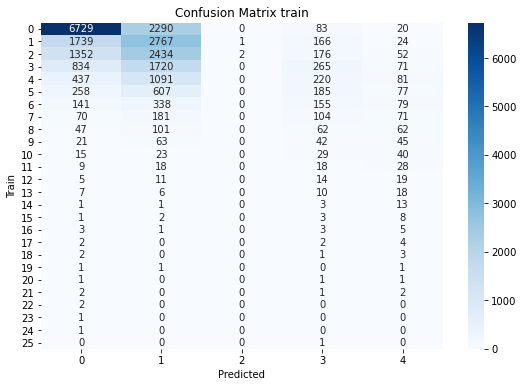

In [62]:
# Representación gráfica de la matriz de confusión sobre el conjunto train.
confusion_matrix_table = pd.crosstab(y_train_3, y_predict_train_3, rownames=['Train'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="Blues", fmt='g')
plt.title("Confusion Matrix train")
plt.savefig('graph/matriz_confusion_DECISONTREEtrain_3.jpg')
plt.show()

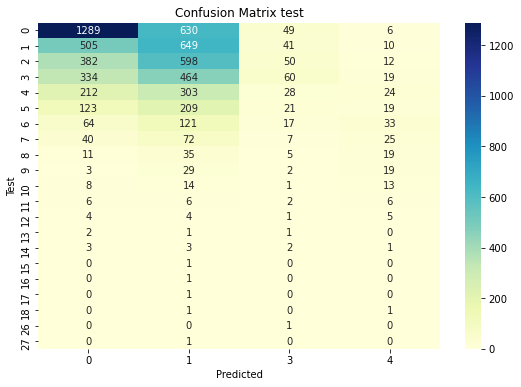

In [63]:
# Representación gráfica de la matriz de confusión sobre el conjunto test.
confusion_matrix_table = pd.crosstab(y_test_3, y_predict_test_3, rownames=['Test'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="YlGnBu", fmt='g')
plt.title("Confusion Matrix test")
plt.savefig('graph/matriz_confusion_DECISONTREEtest_3.jpg')
plt.show()

In [64]:
y_predict = pd.read_excel('data/y_predictsvm.xls')
test_preds_Tree_3 = y_predict_test_3.astype(int)
y_predict['test_preds_Tree_3'] = test_preds_Tree_3
y_predict.to_excel('data/y_predictsvm.xls')

#### 3.4.3.4 Árbol decisión para la modelo con variable _udsVenta_ categorizada en 14 intervalos de igual tamaño.

In [65]:
# Se define el modelo Decision Tree simple para los mejores parámetros
model_tree4 = DecisionTreeClassifier(max_depth=8, min_samples_split=100)

# Entrena el modelo para el conjunto train reducido a días abierto
model_tree4.fit(x_train, y_train_4)

DecisionTreeClassifier(max_depth=8, min_samples_split=100)

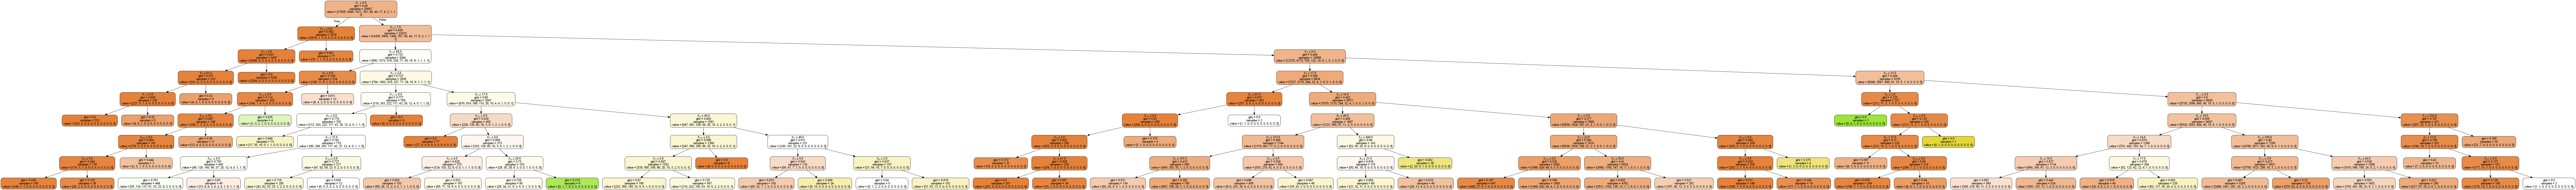

In [66]:
# Representación del árbol de decisión.
dot_data = StringIO()
export_graphviz(model_tree4, out_file = dot_data,
                filled = True, rounded = True,
                special_characters = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [67]:
# Precisión sobre train y test
score_train = model_tree4.score(x_train, y_train_4)
print('El grado de precisión del modelo para el conjunto train es {}.'.format(round(score_train,4)))
score_test = model_tree4.score(x_test, y_test_4)
print('El grado de precisión del modelo para el conjunto test es {}.'.format(round(score_test,4)))

# Predicciones sobre conjunto train y test
y_predict_train_4 = model_tree4.predict(x_train)
y_predict_test_4 = model_tree4.predict(x_test)

El grado de precisión del modelo para el conjunto train es 0.718.
El grado de precisión del modelo para el conjunto test es 0.6245.


In [68]:
#Vemos el error del algoritmo a la hora de predecir, para comprobar si a ajustado bien.
print('MAE in train:', mean_absolute_error(y_predict_train_4, y_train_4))
print('RMSE in train:', np.sqrt(mean_squared_error(y_predict_train_4, y_train_4)))
print('MAE in test:', mean_absolute_error(y_predict_test_4, y_test_4))
print('RMSE in test:', np.sqrt(mean_squared_error(y_predict_test_4, y_test_4)))

MAE in train: 0.3445151716327567
RMSE in train: 0.7205240582915685
MAE in test: 0.4735254186151757
RMSE in test: 0.8716898035378146


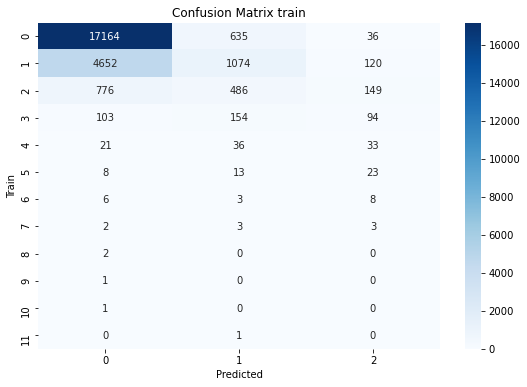

In [69]:
# Representación gráfica de la matriz de confusión sobre el conjunto train.
confusion_matrix_table = pd.crosstab(y_train_4, y_predict_train_4, rownames=['Train'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="Blues", fmt='g')
plt.title("Confusion Matrix train")
plt.savefig('graph/matriz_confusion_DECISONTREEtrain_4.jpg')
plt.show()

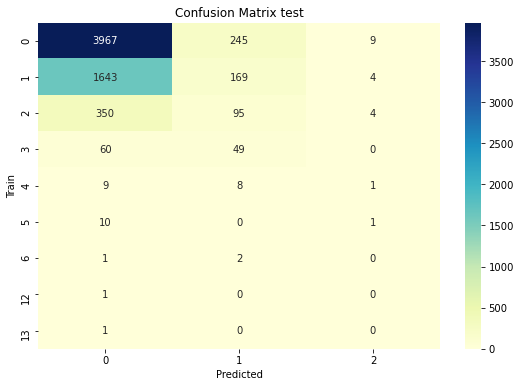

In [70]:
# Representación gráfica de la matriz de confusión sobre el conjunto test.
confusion_matrix_table = pd.crosstab(y_test_4, y_predict_test_4, rownames=['Train'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="YlGnBu", fmt='g')
plt.title("Confusion Matrix test")
plt.savefig('graph/matriz_confusion_DECISONTREEtest_4.jpg')
plt.show()

In [71]:
y_predict = pd.read_excel('data/y_predictsvm.xls')
test_preds_Tree_4 = y_predict_test_4.astype(int)
y_predict['test_preds_Tree_4'] = test_preds_Tree_4
y_predict.to_excel('data/y_predictsvm.xls')

##### 3.4.3.5 Árbol de decisión para la variable _udsVenta_ categorizada en 7 intervalos y bolOpen=1 (abierto).  
Por último, se prueba nuevamente para la variable categórica y_train2_2;  

  - udsVenta discretizada en intervalos de igual amplitud.
  - sólo días abiertos (bolOpen = 1).  

In [72]:
# Optimizar
tree_optimizer = GridSearchCV(estimator=DecisionTreeClassifier(),
                             param_grid=grid_tree,
                             n_jobs=-1,
                             scoring='accuracy',
                             refit = True,
                             cv=cv,
                             error_score=0)

grid_tree_optimizer = tree_optimizer.fit(x_train2, y_train2_2)

# Obtener la mejor combinación del clasificador.
print ('La mejor configuración de parámetros que maximiza la precisión es {}.'.format(grid_tree_optimizer.best_params_))
print ('Clases de clasificación del modelo {}.'.format(grid_tree_optimizer.classes_))

# Obtenemos la precisión del modelo
print('Precisión del modelo {}.'.format(round(grid_tree_optimizer.score(x_train2, y_train2_2),4)))

C:\Users\jh100\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


La mejor configuración de parámetros que maximiza la precisión es {'max_depth': 9, 'min_samples_split': 100}.
Clases de clasificación del modelo [0 1 2 3 4 5].
Precisión del modelo 0.9201.


In [73]:
# Se define el modelo Decision Tree simple para los mejores parámetros
model_tree6 = DecisionTreeClassifier(max_depth=7, min_samples_split=500)

# Entrena el modelo para el conjunto train reducido a días abierto
model_tree6.fit(x_train2, y_train2_2)

DecisionTreeClassifier(max_depth=7, min_samples_split=500)

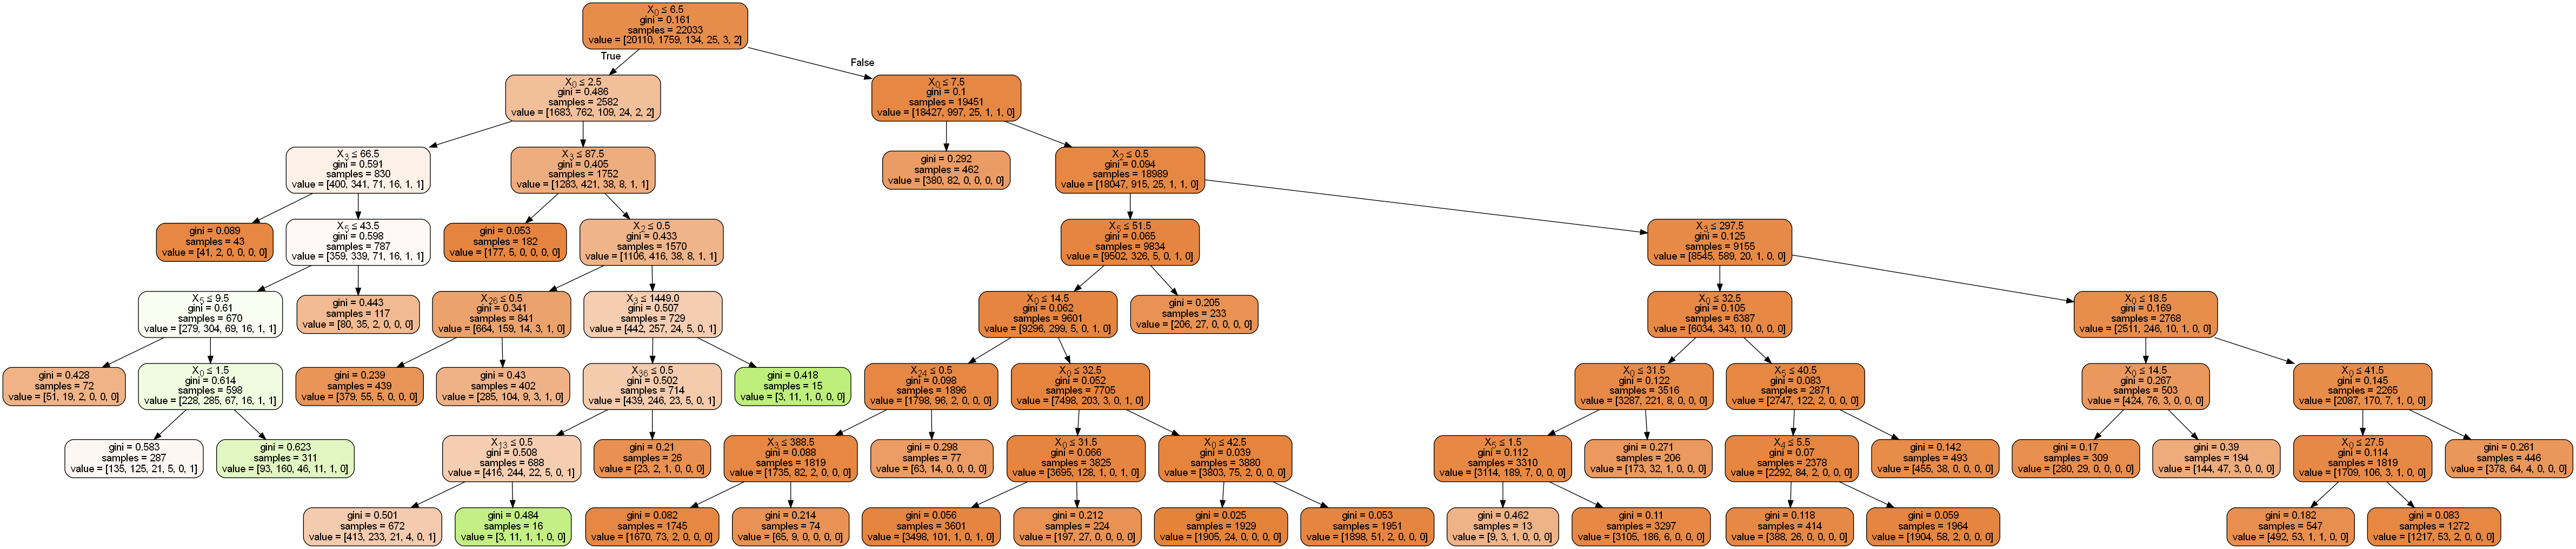

In [74]:
# Representación del árbol de decisión.
dot_data = StringIO()
export_graphviz(model_tree6, out_file = dot_data,
                filled = True, rounded = True,
                special_characters = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [75]:
# Precisión sobre train y test
score_train = model_tree6.score(x_train2, y_train2_2)
print('El grado de precisión del modelo para el conjunto train es {}.'.format(round(score_train,4)))
score_test = model_tree6.score(x_test2, y_test2_2)
print('El grado de precisión del modelo para el conjunto test es {}.'.format(round(score_test,4)))

# Predicciones sobre conjunto train y test
y_predict_train6 = model_tree6.predict(x_train2)
y_predict_test6 = model_tree6.predict(x_test2)

El grado de precisión del modelo para el conjunto train es 0.9165.
El grado de precisión del modelo para el conjunto test es 0.894.


In [76]:
#Vemos el error del algoritmo a la hora de predecir, para comprobar si a ajustado bien.
print('MAE in train:', mean_absolute_error(y_predict_train6, y_train2_2))
print('RMSE in train:', np.sqrt(mean_squared_error(y_predict_train6, y_train2_2)))
print('MAE in test:', mean_absolute_error(y_predict_test6, y_test2_2))
print('RMSE in test:', np.sqrt(mean_squared_error(y_predict_test6, y_test2_2)))

MAE in train: 0.08986520219670495
RMSE in train: 0.3247739928269173
MAE in test: 0.11334218386989711
RMSE in test: 0.36821075077514004


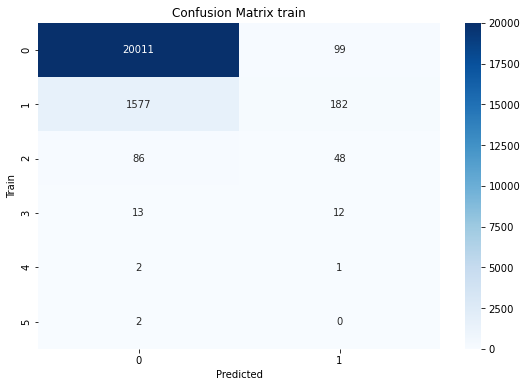

In [77]:
# Representación gráfica de la matriz de confusión sobre el conjunto train.
confusion_matrix_table = pd.crosstab(y_train2_2, y_predict_train6, rownames=['Train'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="Blues", fmt='g')
plt.title("Confusion Matrix train")
plt.savefig('graph/matriz_confusion_DECISONTREEtrain2_2.jpg')
plt.show()

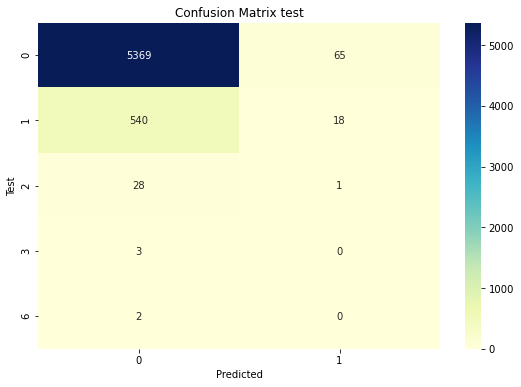

In [78]:
# Representación gráfica de la matriz de confusión sobre el conjunto test.
confusion_matrix_table = pd.crosstab(y_test2_2, y_predict_test6, rownames=['Test'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="YlGnBu", fmt='g')
plt.title("Confusion Matrix test")
plt.savefig('graph/matriz_confusion_DECISONTREEtest2_2.jpg')
plt.show()

#### 3.4.3.6 Árbol decisión, para la variable _udsVenta_ categorizada en 24 clases y para días bolOpen = 1.   
Veamos a continuación el mejor modelo de árbol decisión, ahora sólo para días en que el establecimiento se encuentra abierto.  

In [79]:
# Definición de los conjuntos parámetro
max_depth = [4, 5, 6, 7, 8, 9, 10]
min_samples_split = [20, 50, 100, 500]

grid_tree = dict(max_depth=max_depth, min_samples_split=min_samples_split)
cv =  StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

# Optimizar
tree_optimizer = GridSearchCV(estimator=DecisionTreeClassifier(),
                             param_grid=grid_tree,
                             n_jobs=-1,
                             scoring='accuracy',
                             refit = True,
                             cv=cv,
                             error_score=0)

grid_tree_optimizer = tree_optimizer.fit(x_train2, y_train2_3)

# Obtener la mejor combinación del clasificador SVM
print ('La mejor configuración de parámetros que maximiza la precisión es {}.'.format(grid_tree_optimizer.best_params_))
print ('Clases de clasificación del modelo {}.'.format(grid_tree_optimizer.classes_))

# Obtenemos la precisión del modelo
print('Precisión del modelo {}.'.format(round(grid_tree_optimizer.score(x_train2, y_train2_3),4)))

C:\Users\jh100\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


La mejor configuración de parámetros que maximiza la precisión es {'max_depth': 9, 'min_samples_split': 50}.
Clases de clasificación del modelo [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25].
Precisión del modelo 0.2987.


In [80]:
# Se define el modelo Decision Tree simple para los mejores parámetros
model_tree5 = DecisionTreeClassifier(max_depth=10, min_samples_split=100)

# Entrena el modelo para el conjunto train reducido a días abierto
model_tree5.fit(x_train2, y_train2_3)

DecisionTreeClassifier(max_depth=10, min_samples_split=100)

In [81]:
# Representación del árbol de decisión.
dot_data = StringIO()
export_graphviz(model_tree5, out_file = dot_data,
                filled = True, rounded = True,
                special_characters = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [82]:
# Precisión sobre train y test
score_train = model_tree5.score(x_train2, y_train2_3)
print('El grado de precisión del modelo para el conjunto train es {}.'.format(round(score_train,4)))
score_test = model_tree5.score(x_test2, y_test2_3)
print('El grado de precisión del modelo para el conjunto test es {}.'.format(round(score_test,4)))

# Predicciones sobre conjunto train y test
y_predict_train5 = model_tree5.predict(x_train2)
y_predict_test5 = model_tree5.predict(x_test2)

El grado de precisión del modelo para el conjunto train es 0.3048.
El grado de precisión del modelo para el conjunto test es 0.2355.


In [83]:
#Vemos el error del algoritmo a la hora de predecir, para comprobar si a ajustado bien.
print('MAE in train:', mean_absolute_error(y_predict_train5, y_train2_3))
print('RMSE in train:', np.sqrt(mean_squared_error(y_predict_train5, y_train2_3)))
print('MAE in test:', mean_absolute_error(y_predict_test5, y_test2_3))
print('RMSE in test:', np.sqrt(mean_squared_error(y_predict_test5, y_test2_3)))

MAE in train: 1.6127172877048064
RMSE in train: 2.4367550462548846
MAE in test: 1.946896780617325
RMSE in test: 2.793834186026607


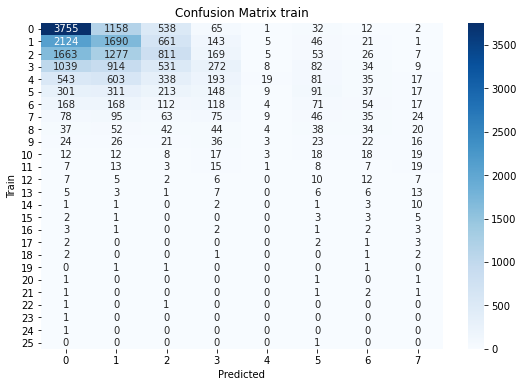

In [84]:
# Representación gráfica de la matriz de confusión sobre el conjunto train.
confusion_matrix_table = pd.crosstab(y_train2_3, y_predict_train5, rownames=['Train'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="Blues", fmt='g')
plt.title("Confusion Matrix train")
plt.savefig('graph/matriz_confusion_DECISONTREEtrain2_3.jpg')
plt.show()

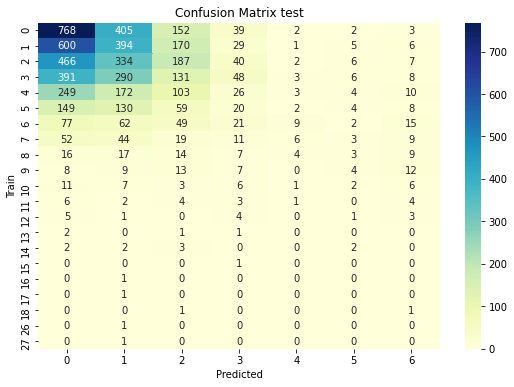

In [85]:
# Representación gráfica de la matriz de confusión sobre el conjunto test.
confusion_matrix_table = pd.crosstab(y_test2_3, y_predict_test5, rownames=['Train'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="YlGnBu", fmt='g')
plt.title("Confusion Matrix test")
plt.savefig('graph/matriz_confusion_DECISONTREEtest2_3.jpg')
plt.show()

Se han probado diferentes combinaciones, y con el que mejor porcentaje de precisión se obtiene es con la variable udsVenta categorizada en intervalos de igual amplitud y sólo para días bolOpen = 1.  

#### 3.4.4 Algoritmo Gradiente Boosting Regressor.  
Este algoritmo combina algoritmo de árbol de decisión con regresión. Entre las diversas categorizaciones posibles, y activar el filtro de sólo dias abierto, la que mejor precisión ha dado en los anteriores algoritmos es;     
  - categorizar _udsVenta_ en 7 intervalos de igual tamaño.   
  - considerar todos los días.   

In [86]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

model_GBR = DecisionTreeRegressor(max_depth = 10,
                                   criterion = 'mse')
c = cross_val_score(model_GBR, x_train, y_train_2, cv=6).mean()
print('La precisión media del modelo aplicado al conjunto train, es:',round(c*100,2),'%')

La precisión media del modelo aplicado al conjunto train, es: -56.33 %


Se entrena el modelo para el conjunto completo y variable _udsVenta_ discretizada en 7 intervalos de igual tamaño.

In [87]:
# Definición de los conjuntos parámetro
max_depth = [4, 5, 6, 7, 8, 9, 10]
min_samples_split = [20, 50, 100, 500]

grid_tree = dict(max_depth=max_depth, min_samples_split=min_samples_split)
cv =  StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

# Optimizar
GBR_optimizer = GridSearchCV(estimator=DecisionTreeRegressor(),
                             param_grid=grid_tree,
                             n_jobs=-1,
                             scoring='accuracy',
                             refit = True,
                             cv = 7,
                             error_score=0)

grid_GBR_optimizer = GBR_optimizer.fit(x_train, y_train_2)

# Obtener la mejor combinación del clasificador GBR
print ('La mejor configuración de parámetros que maximiza la precisión es {}.'.format(grid_GBR_optimizer.best_params_))

La mejor configuración de parámetros que maximiza la precisión es {'max_depth': 4, 'min_samples_split': 20}.


In [88]:
model_GBR = DecisionTreeRegressor(max_depth = 4,
                                   min_samples_split = 20,
                                   criterion = 'mse')

# Entrena el modelo para el conjunto train reducido a días abierto
model_GBR.fit(x_train, y_train_2)

DecisionTreeRegressor(max_depth=4, min_samples_split=20)

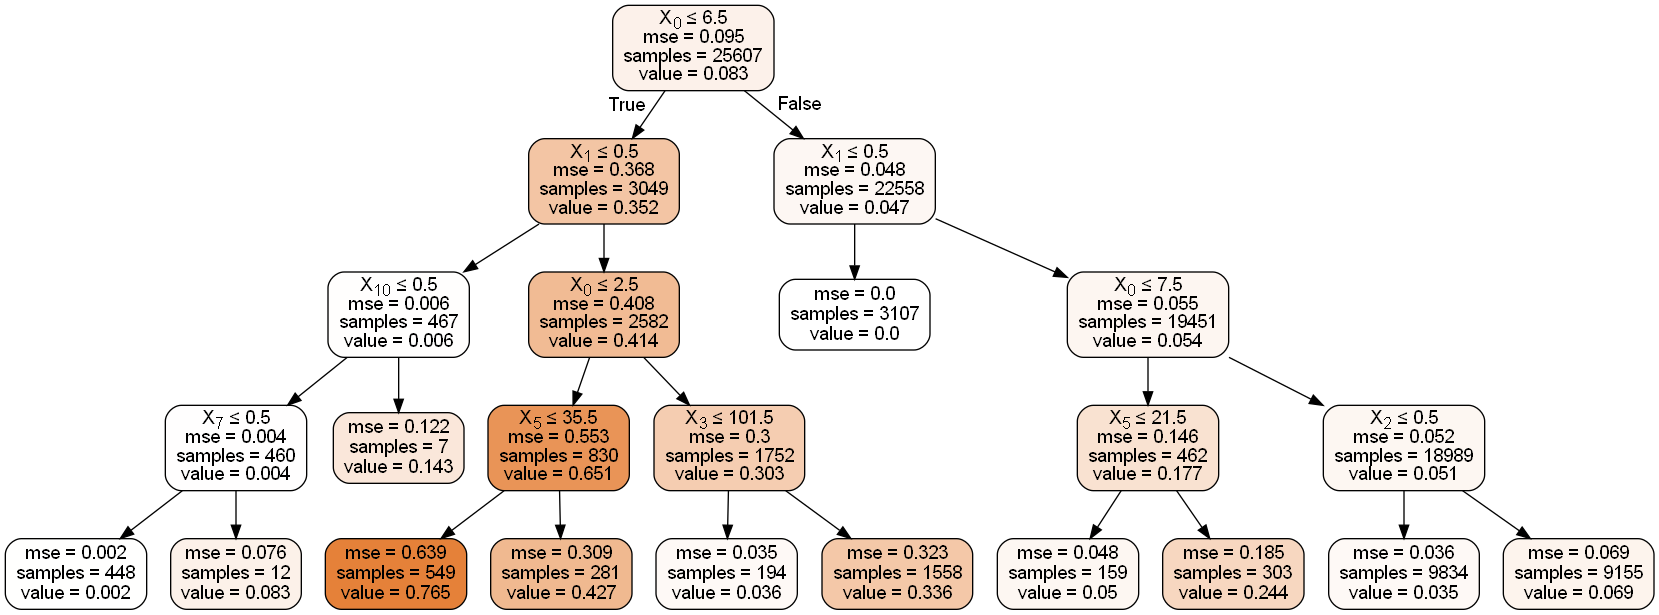

In [89]:
# Representación del árbol de decisión.
dot_data = StringIO()
export_graphviz(model_GBR, out_file = dot_data,
                filled = True, rounded = True,
                special_characters = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [90]:
# Precisión sobre train y test
score_train = model_GBR.score(x_train, y_train_2)
print('El grado de precisión del modelo para el conjunto train es {}.'.format(round(score_train,4)))
score_test = model_GBR.score(x_test, y_test_2)
print('El grado de precisión del modelo para el conjunto test es {}.'.format(round(score_test,4)))

# Predicciones sobre conjunto train y test
y_predict_train_GBR = model_GBR.predict(x_train)
y_predict_test_GBR = model_GBR.predict(x_test)

El grado de precisión del modelo para el conjunto train es 0.1824.
El grado de precisión del modelo para el conjunto test es 0.058.


In [91]:
c = cross_val_score(model_GBR, x_train, y_train_2, cv=4).mean()
print('La precisión media del modelo aplicado al conjunto train, es:',round(c*100,2),'%')

La precisión media del modelo aplicado al conjunto train, es: -2.63 %


In [92]:
#Vemos el error del algoritmo a la hora de predecir, para comprobar si a ajustado bien.
print('MAE in train:', mean_absolute_error(y_predict_train_GBR, y_train_2))
print('RMSE in train:', np.sqrt(mean_squared_error(y_predict_train_GBR, y_train_2)))
print('MAE in test:', mean_absolute_error(y_predict_test_GBR, y_test_2))
print('RMSE in test:', np.sqrt(mean_squared_error(y_predict_test_GBR, y_test_2)))

MAE in train: 0.1255845564528449
RMSE in train: 0.2793681590905569
MAE in test: 0.1481214866850737
RMSE in test: 0.31804488346915055


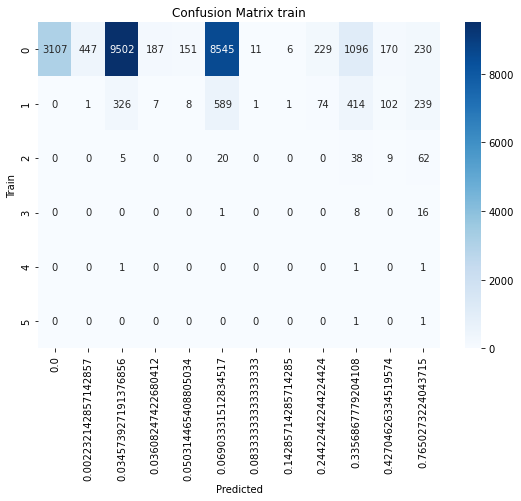

In [93]:
# Representación gráfica de la matriz de confusión sobre el conjunto train.
confusion_matrix_table = pd.crosstab(y_train_2, y_predict_train_GBR, rownames=['Train'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="Blues", fmt='g')
plt.title("Confusion Matrix train")
plt.savefig('graph/matriz_confusion_GBRtrain_2.jpg')
plt.show()

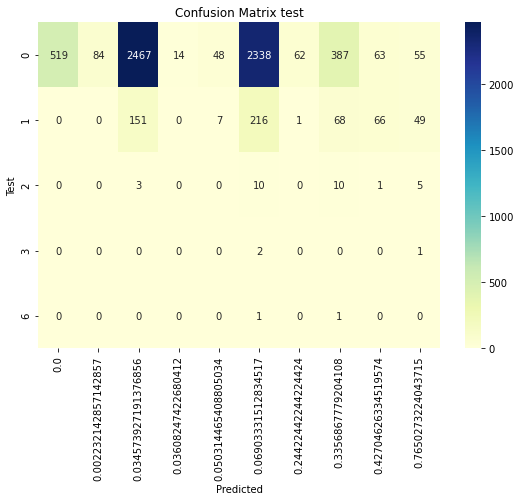

In [94]:
# Representación gráfica de la matriz de confusión sobre el conjunto test.
confusion_matrix_table = pd.crosstab(y_test_2, y_predict_test_GBR, rownames=['Test'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="YlGnBu", fmt='g')
plt.title("Confusion Matrix test")
plt.savefig('graph/matriz_confusion_GBRtest_2.jpg')
plt.show()

In [95]:
y_predict = pd.read_excel('data/y_predictsvm.xls')
test_preds_GradientBoosting = y_predict_test_GBR.astype(int)
y_predict['test_preds_GradientBoosting'] = test_preds_GradientBoosting
y_predict.to_excel('data/y_predictsvm.xls')

#### 3.4.5 Algoritmo Arbol de Decisión de Gradiente Creciente (XGBoost).  
Se aborda en este apartado el diseño de un modelo de predicción de la demanda a partir de algoritmo Gradiente Boosting Classifier, basado en árbol de decisión mejorado mediante sistema boosting.  
Al igual que en el algoritmo GBR, se entrena con el fichero de _udsVenta_ categorizado en 7 intervalos de igual tamaño, y sin filtro en bolOpen.   

In [96]:
# Definición de los conjuntos parámetro
max_depth = [4, 5, 6, 7, 8, 9, 10]
min_samples_split = [20, 50, 100, 500]

grid_tree = dict(max_depth=max_depth, min_samples_split=min_samples_split)
cv =  StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

# Optimizar
tree_optimizer = GridSearchCV(estimator=GradientBoostingClassifier(),
                             param_grid=grid_tree,
                             n_jobs=-1,
                             scoring='accuracy',
                             refit = True,
                             cv=cv,
                             error_score=0)

grid_tree_optimizer = tree_optimizer.fit(x_train, y_train_2)

# Obtener la mejor combinación del clasificador XGBoost
print ('La mejor configuración de parámetros que maximiza la precisión es {}.'.format(grid_tree_optimizer.best_params_))
print ('Clases de clasificación del modelo {}.'.format(grid_tree_optimizer.classes_))

# Obtenemos la precisión del modelo
print('Precisión del modelo {}.'.format(round(grid_tree_optimizer.score(x_train, y_train_2),4)))

C:\Users\jh100\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


La mejor configuración de parámetros que maximiza la precisión es {'max_depth': 4, 'min_samples_split': 500}.
Clases de clasificación del modelo [0 1 2 3 4 5].
Precisión del modelo 0.9333.


In [97]:
model_boosting = GradientBoostingClassifier(n_estimators=7,
                                            max_depth=5,
                                            min_samples_split = 100,
                                            learning_rate=0.01,
                                            criterion='mse')
c = cross_val_score(model_boosting, x_train, y_train_2, cv=7).mean()
print('La precisión media del modelo aplicado al conjunto train, es:',round(c*100,2),'%')

C:\Users\jh100\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=7.
  % (min_groups, self.n_splits)), UserWarning)


La precisión media del modelo aplicado al conjunto train, es: 91.23 %


In [98]:
b = cross_val_score(model_boosting, x_test, y_test_2, cv=7).mean()
print('La precisión media del modelo aplicado al conjunto test, es:',round(b*100,2),'%')

C:\Users\jh100\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=7.
  % (min_groups, self.n_splits)), UserWarning)


La precisión media del modelo aplicado al conjunto test, es: 80.34 %


In [99]:
gradient_boosting = model_boosting.fit(x_train, y_train_2)

In [100]:
# Precisión sobre train y test
score_train = gradient_boosting.score(x_train, y_train_2)
print('El grado de precisión del modelo para el conjunto train es {}.'.format(round(score_train,4)))
score_test = gradient_boosting.score(x_test, y_test_2)
print('El grado de precisión del modelo para el conjunto test es {}.'.format(round(score_test,4)))

# Predicciones sobre conjunto train y test
y_predict_train_boosting = gradient_boosting.predict(x_train)
y_predict_test_boosting = gradient_boosting.predict(x_test)

El grado de precisión del modelo para el conjunto train es 0.9248.
El grado de precisión del modelo para el conjunto test es 0.9107.


In [101]:
#Vemos el error del algoritmo a la hora de predecir, para comprobar si a ajustado bien.
print('MAE in train:', mean_absolute_error(y_predict_train_boosting, y_train_2))
print('RMSE in train:', np.sqrt(mean_squared_error(y_predict_train_boosting, y_train_2)))
print('MAE in test:', mean_absolute_error(y_predict_test_boosting, y_test_2))
print('RMSE in test:', np.sqrt(mean_squared_error(y_predict_test_boosting, y_test_2)))

MAE in train: 0.08306322489944155
RMSE in train: 0.31992940604542647
MAE in test: 0.09609292502639916
RMSE in test: 0.34148036538825066


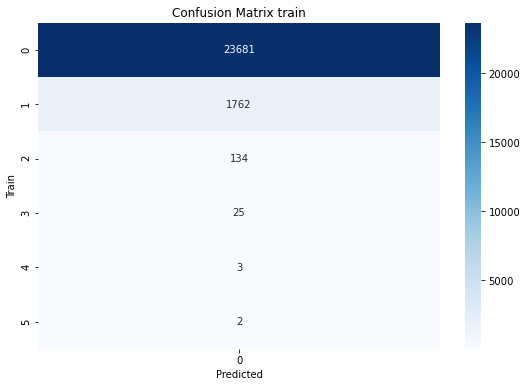

In [102]:
# Representación gráfica de la matriz de confusión sobre el conjunto train.
confusion_matrix_table = pd.crosstab(y_train_2, y_predict_train_boosting, rownames=['Train'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="Blues", fmt='g')
plt.title("Confusion Matrix train")
plt.savefig('graph/matriz_confusion_XGBoosttrain_2.jpg')
plt.show()

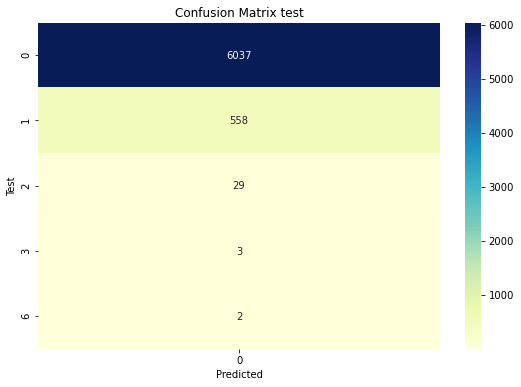

In [103]:
# Representación gráfica de la matriz de confusión sobre el conjunto test.
confusion_matrix_table = pd.crosstab(y_test_2, y_predict_test_boosting, rownames=['Test'], colnames=['Predicted'])
plt.figure(1, figsize=(9, 6))
sn.heatmap(confusion_matrix_table, annot=True, cmap="YlGnBu", fmt='g')
plt.title("Confusion Matrix test")
plt.savefig('graph/matriz_confusion_XGBoosttest_2.jpg')
plt.show()

In [104]:
y_predict = pd.read_excel('data/y_predictsvm.xls')
test_preds_XGBoost = y_predict_test_boosting.astype(int)
y_predict['test_preds_XGBoosting'] = test_preds_XGBoost
y_predict.to_excel('data/y_predictsvm.xls')

### 3.4.6 Algoritmo redes neuronales.  
Vease ahora otros algoritmos de Machine Learning aplicando redes neuronales.   

#### 3.4.6.1 Red neuronal para la variable _udsVenta_ discretizada en 7 intervalos de igual tamaño.     
Se entrena modelo basado en redes neuronales para 7 clases.    
 - 4 capas ocultas con 64, 32, 10, 8 neuronas   
 - Función de activación elu y ReLU  

In [146]:
# Número de clases
num_classes = 7

model_neuronal2 = Sequential()

# Añadir las capas indicadas
model_neuronal2.add(Dense(64, input_shape=(44,), activation="relu", kernel_initializer="random_normal", bias_initializer="zeros"))
model_neuronal2.add(Dense(32, activation="elu"))
model_neuronal2.add(Dense(10, activation="relu"))
model_neuronal2.add(Dense(8, activation="relu"))
model_neuronal2.add(Dense(num_classes, activation="softmax"))

In [145]:
ohe = OneHotEncoder ()
y_train_transf2 = pd.get_dummies(
    y_train_2,columns=['udsVenta'])
y_test_transf2 = pd.get_dummies(
    y_test_2, columns=['udsVenta'])

In [147]:
# Se compila el modelo con la función de perdida más adecuada. 
model_neuronal2.compile(
    optimizer=Adam(lr=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'mse'])

In [148]:
batch = x_train.shape[0]
history = model_neuronal2.fit(
    x_train, y_train_transf2,
    validation_data=(x_test, y_test_transf2),
    epochs=300,
    batch_size=batch,
    verbose=2)

Train on 25607 samples, validate on 6629 samples
Epoch 1/300
 - 0s - loss: 15.2290 - accuracy: 0.0683 - mse: 0.2436 - val_loss: 9.4915 - val_accuracy: 0.0054 - val_mse: 0.2643
Epoch 2/300
 - 0s - loss: 9.0929 - accuracy: 0.0056 - mse: 0.2656 - val_loss: 4.9722 - val_accuracy: 0.0318 - val_mse: 0.2227
Epoch 3/300
 - 0s - loss: 4.7880 - accuracy: 0.0139 - mse: 0.2139 - val_loss: 2.7453 - val_accuracy: 0.0733 - val_mse: 0.1599
Epoch 4/300
 - 0s - loss: 2.6958 - accuracy: 0.0506 - mse: 0.1540 - val_loss: 2.3192 - val_accuracy: 0.1551 - val_mse: 0.1670
Epoch 5/300
 - 0s - loss: 2.2496 - accuracy: 0.1766 - mse: 0.1553 - val_loss: 0.9572 - val_accuracy: 0.7823 - val_mse: 0.0693
Epoch 6/300
 - 0s - loss: 0.9489 - accuracy: 0.8828 - mse: 0.0669 - val_loss: 0.6058 - val_accuracy: 0.9107 - val_mse: 0.0409
Epoch 7/300
 - 0s - loss: 0.6408 - accuracy: 0.9248 - mse: 0.0421 - val_loss: 0.4981 - val_accuracy: 0.9107 - val_mse: 0.0319
Epoch 8/300
 - 0s - loss: 0.5196 - accuracy: 0.9248 - mse: 0.0311 - 

Epoch 66/300
 - 0s - loss: 0.2705 - accuracy: 0.9248 - mse: 0.0188 - val_loss: 0.3194 - val_accuracy: 0.9107 - val_mse: 0.0228
Epoch 67/300
 - 0s - loss: 0.2701 - accuracy: 0.9248 - mse: 0.0188 - val_loss: 0.3188 - val_accuracy: 0.9107 - val_mse: 0.0228
Epoch 68/300
 - 0s - loss: 0.2698 - accuracy: 0.9248 - mse: 0.0188 - val_loss: 0.3187 - val_accuracy: 0.9107 - val_mse: 0.0228
Epoch 69/300
 - 0s - loss: 0.2695 - accuracy: 0.9248 - mse: 0.0188 - val_loss: 0.3188 - val_accuracy: 0.9107 - val_mse: 0.0228
Epoch 70/300
 - 0s - loss: 0.2692 - accuracy: 0.9248 - mse: 0.0187 - val_loss: 0.3191 - val_accuracy: 0.9107 - val_mse: 0.0227
Epoch 71/300
 - 0s - loss: 0.2689 - accuracy: 0.9248 - mse: 0.0187 - val_loss: 0.3195 - val_accuracy: 0.9107 - val_mse: 0.0227
Epoch 72/300
 - 0s - loss: 0.2687 - accuracy: 0.9248 - mse: 0.0187 - val_loss: 0.3196 - val_accuracy: 0.9107 - val_mse: 0.0227
Epoch 73/300
 - 0s - loss: 0.2685 - accuracy: 0.9248 - mse: 0.0187 - val_loss: 0.3192 - val_accuracy: 0.9107 - 

Epoch 131/300
 - 0s - loss: 0.2571 - accuracy: 0.9248 - mse: 0.0182 - val_loss: 0.3060 - val_accuracy: 0.9107 - val_mse: 0.0219
Epoch 132/300
 - 0s - loss: 0.2548 - accuracy: 0.9248 - mse: 0.0181 - val_loss: 0.3087 - val_accuracy: 0.9107 - val_mse: 0.0221
Epoch 133/300
 - 0s - loss: 0.2565 - accuracy: 0.9248 - mse: 0.0182 - val_loss: 0.3047 - val_accuracy: 0.9107 - val_mse: 0.0219
Epoch 134/300
 - 0s - loss: 0.2548 - accuracy: 0.9248 - mse: 0.0181 - val_loss: 0.3060 - val_accuracy: 0.9107 - val_mse: 0.0219
Epoch 135/300
 - 0s - loss: 0.2545 - accuracy: 0.9248 - mse: 0.0180 - val_loss: 0.3114 - val_accuracy: 0.9107 - val_mse: 0.0221
Epoch 136/300
 - 0s - loss: 0.2555 - accuracy: 0.9248 - mse: 0.0181 - val_loss: 0.3064 - val_accuracy: 0.9107 - val_mse: 0.0219
Epoch 137/300
 - 0s - loss: 0.2535 - accuracy: 0.9248 - mse: 0.0180 - val_loss: 0.3047 - val_accuracy: 0.9107 - val_mse: 0.0219
Epoch 138/300
 - 0s - loss: 0.2541 - accuracy: 0.9248 - mse: 0.0180 - val_loss: 0.3063 - val_accuracy: 0

 - 0s - loss: 0.2412 - accuracy: 0.9248 - mse: 0.0176 - val_loss: 0.2966 - val_accuracy: 0.9107 - val_mse: 0.0216
Epoch 196/300
 - 0s - loss: 0.2414 - accuracy: 0.9248 - mse: 0.0176 - val_loss: 0.2998 - val_accuracy: 0.9107 - val_mse: 0.0217
Epoch 197/300
 - 0s - loss: 0.2412 - accuracy: 0.9248 - mse: 0.0176 - val_loss: 0.2965 - val_accuracy: 0.9107 - val_mse: 0.0216
Epoch 198/300
 - 0s - loss: 0.2408 - accuracy: 0.9248 - mse: 0.0176 - val_loss: 0.2976 - val_accuracy: 0.9107 - val_mse: 0.0216
Epoch 199/300
 - 0s - loss: 0.2405 - accuracy: 0.9248 - mse: 0.0176 - val_loss: 0.2990 - val_accuracy: 0.9107 - val_mse: 0.0217
Epoch 200/300
 - 0s - loss: 0.2406 - accuracy: 0.9248 - mse: 0.0176 - val_loss: 0.2965 - val_accuracy: 0.9107 - val_mse: 0.0216
Epoch 201/300
 - 0s - loss: 0.2407 - accuracy: 0.9248 - mse: 0.0176 - val_loss: 0.2998 - val_accuracy: 0.9107 - val_mse: 0.0217
Epoch 202/300
 - 0s - loss: 0.2408 - accuracy: 0.9248 - mse: 0.0176 - val_loss: 0.2951 - val_accuracy: 0.9107 - val_ms

Epoch 260/300
 - 0s - loss: 0.2356 - accuracy: 0.9249 - mse: 0.0173 - val_loss: 0.2930 - val_accuracy: 0.9108 - val_mse: 0.0215
Epoch 261/300
 - 0s - loss: 0.2354 - accuracy: 0.9250 - mse: 0.0173 - val_loss: 0.2925 - val_accuracy: 0.9107 - val_mse: 0.0215
Epoch 262/300
 - 0s - loss: 0.2354 - accuracy: 0.9249 - mse: 0.0173 - val_loss: 0.2940 - val_accuracy: 0.9105 - val_mse: 0.0215
Epoch 263/300
 - 0s - loss: 0.2358 - accuracy: 0.9249 - mse: 0.0173 - val_loss: 0.2924 - val_accuracy: 0.9107 - val_mse: 0.0215
Epoch 264/300
 - 0s - loss: 0.2366 - accuracy: 0.9252 - mse: 0.0173 - val_loss: 0.2967 - val_accuracy: 0.9105 - val_mse: 0.0216
Epoch 265/300
 - 0s - loss: 0.2377 - accuracy: 0.9249 - mse: 0.0174 - val_loss: 0.2942 - val_accuracy: 0.9105 - val_mse: 0.0217
Epoch 266/300
 - 0s - loss: 0.2395 - accuracy: 0.9252 - mse: 0.0175 - val_loss: 0.2990 - val_accuracy: 0.9107 - val_mse: 0.0217
Epoch 267/300
 - 0s - loss: 0.2395 - accuracy: 0.9247 - mse: 0.0175 - val_loss: 0.2930 - val_accuracy: 0

In [149]:
model_neuronal2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                2880      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_18 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 88        
_________________________________________________________________
dense_20 (Dense)             (None, 7)                 63        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________


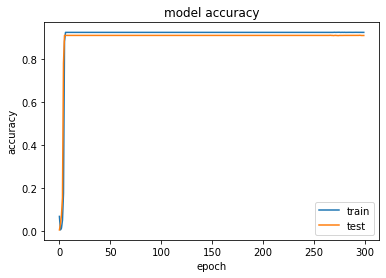

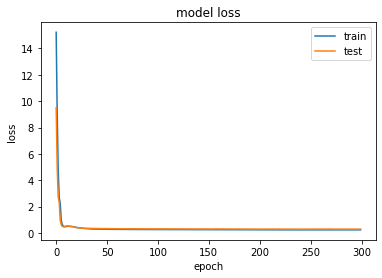

In [150]:
%matplotlib inline

# Visualizamos la evolución de la accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# Visualizamos la evolución del error cometido por la red
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [157]:
# Predicciones sobre conjunto train y test
y_predict_train_NN2 = model_neuronal2.predict(x_train)
y_predict_test_NN2 = model_neuronal2.predict(x_test)

In [160]:
y_predict_train_NN2 = pd.DataFrame(y_predict_train_NN2)
y_predict_train_NN2 = round(y_predict_train_NN2).astype('int')

y_predict_test_NN2 = pd.DataFrame(y_predict_test_NN2)
y_predict_test_NN2 = round(y_predict_test_NN2).astype('int')

In [177]:
# Precisión sobre train y test
score_train = accuracy_score(y_train_transf2, y_predict_train_NN2)
print('El grado de precisión del modelo para el conjunto train es {}.'.
      format(round(score_train,4)))
score_test = accuracy_score(y_test_transf2, y_predict_test_NN2)
print('El grado de precisión del modelo para el conjunto test es {}.'.
      format(round(score_test,4)))

El grado de precisión del modelo para el conjunto train es 0.9169.
El grado de precisión del modelo para el conjunto test es 0.9009.


In [153]:
#Vemos el error del algoritmo a la hora de predecir, para comprobar si a ajustado bien.
print('MAE in train:', mean_absolute_error(y_predict_train_NN2, y_train_transf2))
print('RMSE in train:', np.sqrt(mean_squared_error(y_predict_train_NN2, y_train_transf2)))
print('MAE in test:', mean_absolute_error(y_predict_test_NN2, y_test_transf2))
print('RMSE in test:', np.sqrt(mean_squared_error(y_predict_test_NN2, y_test_transf2)))

MAE in train: 0.020887145813923647
RMSE in train: 0.1445238589781066
MAE in test: 0.02590349761868845
RMSE in test: 0.16094563560000144


In [155]:
# Función matriz confusión.

import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        1

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

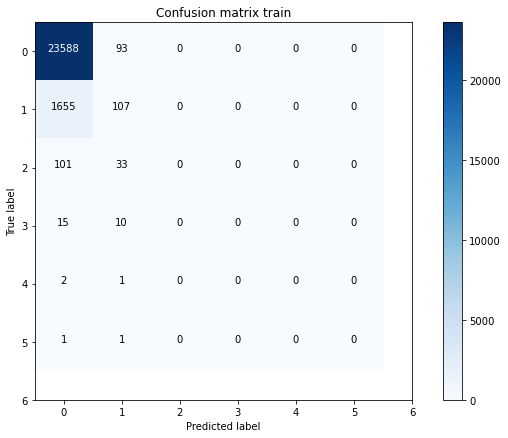

In [165]:
# Convertir dataframe a array
x = model_neuronal2.predict(x_train)
y = y_train_transf2.to_numpy()

# Matriz de confusión train
cm = confusion_matrix(y.argmax(axis=1),
                      x.argmax(axis=1))
np.set_printoptions(precision=2)
class_names = ['0','1', '2', '3', '4', '5', '6']
plt.figure(1, figsize=(9, 6))
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix train')
plt.savefig('graph/matriz_confusion_NN2train_2.jpg')
plt.show()

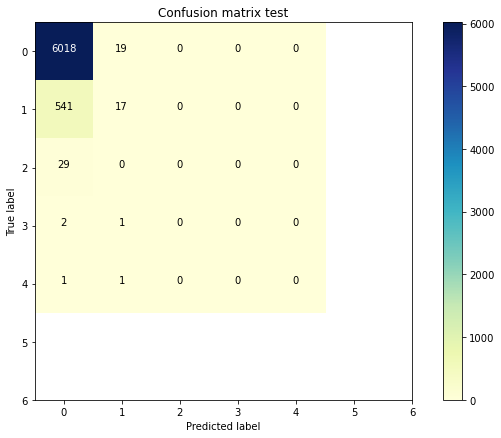

In [166]:
# Convertir dataframe a array
x = model_neuronal2.predict(x_test)
y = y_test_transf2.to_numpy()

# Matriz de confusión test
cm = confusion_matrix(y.argmax(axis=1),
                      x.argmax(axis=1))
np.set_printoptions(precision=2)
class_names = ['0','1', '2', '3', '4', '5', '6']
plt.figure(1, figsize=(9, 6))
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix test',
                      cmap="YlGnBu")
plt.savefig('graph/matriz_confusion_NN2test_2.jpg')
plt.show()

#### 3.4.6.2 Red neuronal para clasificar según clases de _udsVenta_.   
Se implementa red neuronal con una última capa de salida con 28 categorías, una por cada uno de las clases de la variable y_train_3.  
 - 4 capas ocultas con 64, 32, 10, 8 neuronas   
 - Función de activación ReLU   

In [188]:
# Número de clases
num_classes = 28

model_neuronal = Sequential()

# Añadir las capas indicadas
model_neuronal.add(Dense(64, input_shape=(44,), activation="relu", kernel_initializer="random_normal", bias_initializer="zeros"))
model_neuronal.add(Dense(32, activation="relu"))
model_neuronal.add(Dense(10, activation="relu"))
model_neuronal.add(Dense(8, activation="relu"))
model_neuronal.add(Dense(num_classes, activation="softmax"))

Se compila el modelo con la función de pérdida más adecuada. La función de pérdida idónea es la Categorical-Crossentropy, dado que se generan salidas para cada clase de la variable objeto _udsVenta_.  

In [189]:
ohe = OneHotEncoder ()
y_train_transf = pd.get_dummies(
    y_train_3, columns=['udsVenta'])
y_test_transf = pd.get_dummies(
    y_test_3, columns=['udsVenta'])

In [190]:
# Se compila el modelo con la función de perdida más adecuada. 
model_neuronal.compile(
    optimizer=Adam(lr=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'mse'])

In [191]:
batch = x_train.shape[0]
history = model_neuronal.fit(
    x_train, y_train_transf,
    validation_data=(x_test, y_test_transf),
    epochs=200,
    batch_size=batch,
    verbose=2)

Train on 25607 samples, validate on 6629 samples
Epoch 1/200
 - 0s - loss: 6.1206 - accuracy: 0.0300 - mse: 0.0402 - val_loss: 4.3010 - val_accuracy: 0.0071 - val_mse: 0.0371
Epoch 2/200
 - 0s - loss: 4.0946 - accuracy: 0.0054 - mse: 0.0367 - val_loss: 3.5309 - val_accuracy: 0.0106 - val_mse: 0.0352
Epoch 3/200
 - 0s - loss: 3.4764 - accuracy: 0.0072 - mse: 0.0351 - val_loss: 3.1547 - val_accuracy: 0.0146 - val_mse: 0.0338
Epoch 4/200
 - 0s - loss: 3.0956 - accuracy: 0.0131 - mse: 0.0337 - val_loss: 3.0550 - val_accuracy: 0.0388 - val_mse: 0.0334
Epoch 5/200
 - 0s - loss: 3.0151 - accuracy: 0.0431 - mse: 0.0334 - val_loss: 3.0145 - val_accuracy: 0.2827 - val_mse: 0.0332
Epoch 6/200
 - 0s - loss: 2.9820 - accuracy: 0.3412 - mse: 0.0332 - val_loss: 2.9340 - val_accuracy: 0.2079 - val_mse: 0.0326
Epoch 7/200
 - 0s - loss: 2.9139 - accuracy: 0.2082 - mse: 0.0328 - val_loss: 2.9699 - val_accuracy: 0.1546 - val_mse: 0.0319
Epoch 8/200
 - 0s - loss: 2.8923 - accuracy: 0.1309 - mse: 0.0321 - v

Epoch 66/200
 - 0s - loss: 1.8022 - accuracy: 0.3562 - mse: 0.0270 - val_loss: 1.9167 - val_accuracy: 0.2984 - val_mse: 0.0281
Epoch 67/200
 - 0s - loss: 1.7850 - accuracy: 0.3577 - mse: 0.0269 - val_loss: 1.9112 - val_accuracy: 0.2979 - val_mse: 0.0280
Epoch 68/200
 - 0s - loss: 1.7838 - accuracy: 0.3578 - mse: 0.0268 - val_loss: 1.9643 - val_accuracy: 0.2978 - val_mse: 0.0288
Epoch 69/200
 - 0s - loss: 1.8010 - accuracy: 0.3562 - mse: 0.0270 - val_loss: 1.9090 - val_accuracy: 0.2991 - val_mse: 0.0279
Epoch 70/200
 - 0s - loss: 1.7852 - accuracy: 0.3573 - mse: 0.0268 - val_loss: 1.9277 - val_accuracy: 0.2978 - val_mse: 0.0282
Epoch 71/200
 - 0s - loss: 1.7751 - accuracy: 0.3562 - mse: 0.0267 - val_loss: 1.9089 - val_accuracy: 0.2987 - val_mse: 0.0279
Epoch 72/200
 - 0s - loss: 1.7673 - accuracy: 0.3581 - mse: 0.0266 - val_loss: 1.9003 - val_accuracy: 0.2990 - val_mse: 0.0278
Epoch 73/200
 - 0s - loss: 1.7654 - accuracy: 0.3587 - mse: 0.0266 - val_loss: 1.9468 - val_accuracy: 0.2978 - 

Epoch 131/200
 - 0s - loss: 1.7487 - accuracy: 0.3567 - mse: 0.0264 - val_loss: 1.8854 - val_accuracy: 0.3047 - val_mse: 0.0275
Epoch 132/200
 - 0s - loss: 1.7130 - accuracy: 0.3569 - mse: 0.0257 - val_loss: 1.8330 - val_accuracy: 0.3242 - val_mse: 0.0269
Epoch 133/200
 - 0s - loss: 1.6952 - accuracy: 0.3667 - mse: 0.0255 - val_loss: 1.8337 - val_accuracy: 0.3243 - val_mse: 0.0270
Epoch 134/200
 - 0s - loss: 1.7156 - accuracy: 0.3580 - mse: 0.0258 - val_loss: 1.8263 - val_accuracy: 0.3195 - val_mse: 0.0268
Epoch 135/200
 - 0s - loss: 1.7043 - accuracy: 0.3614 - mse: 0.0255 - val_loss: 1.8383 - val_accuracy: 0.3094 - val_mse: 0.0271
Epoch 136/200
 - 0s - loss: 1.6878 - accuracy: 0.3586 - mse: 0.0253 - val_loss: 1.8905 - val_accuracy: 0.2972 - val_mse: 0.0279
Epoch 137/200
 - 0s - loss: 1.7132 - accuracy: 0.3564 - mse: 0.0257 - val_loss: 1.8235 - val_accuracy: 0.3154 - val_mse: 0.0268
Epoch 138/200
 - 0s - loss: 1.6735 - accuracy: 0.3634 - mse: 0.0251 - val_loss: 1.8159 - val_accuracy: 0

Epoch 196/200
 - 0s - loss: 1.6315 - accuracy: 0.3706 - mse: 0.0246 - val_loss: 1.8160 - val_accuracy: 0.3221 - val_mse: 0.0268
Epoch 197/200
 - 0s - loss: 1.6344 - accuracy: 0.3703 - mse: 0.0247 - val_loss: 1.7957 - val_accuracy: 0.3270 - val_mse: 0.0264
Epoch 198/200
 - 0s - loss: 1.6442 - accuracy: 0.3773 - mse: 0.0248 - val_loss: 1.7979 - val_accuracy: 0.3255 - val_mse: 0.0265
Epoch 199/200
 - 0s - loss: 1.6341 - accuracy: 0.3776 - mse: 0.0247 - val_loss: 1.8457 - val_accuracy: 0.3204 - val_mse: 0.0272
Epoch 200/200
 - 0s - loss: 1.6578 - accuracy: 0.3629 - mse: 0.0250 - val_loss: 1.8082 - val_accuracy: 0.3242 - val_mse: 0.0266


In [192]:
model_neuronal.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 64)                2880      
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 88        
_________________________________________________________________
dense_25 (Dense)             (None, 28)                252       
Total params: 5,630
Trainable params: 5,630
Non-trainable params: 0
_________________________________________________________________


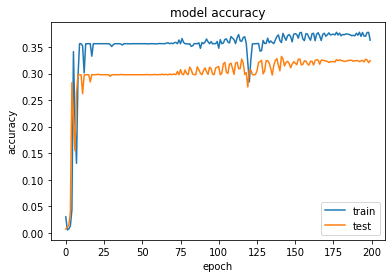

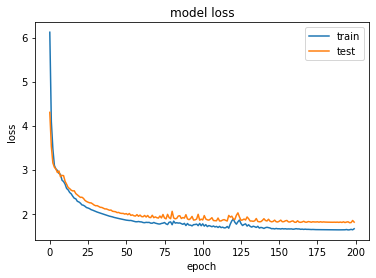

In [193]:
%matplotlib inline

# Visualizamos la evolución de la accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# Visualizamos la evolución del error cometido por la red
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [194]:
# Predicciones sobre conjunto train y test
y_predict_train_NN = model_neuronal.predict(x_train)
y_predict_test_NN = model_neuronal.predict(x_test)

In [195]:
y_predict_train_NN = pd.DataFrame(y_predict_train_NN)
y_predict_train_NN = round(y_predict_train_NN).astype('int')

y_predict_test_NN = pd.DataFrame(y_predict_test_NN)
y_predict_test_NN = round(y_predict_test_NN).astype('int')

In [196]:
# Precisión sobre train y test
score_train = accuracy_score(y_train_transf, y_predict_train_NN)
print('El grado de precisión del modelo para el conjunto train es {}.'.
      format(round(score_train,4)))
score_test = accuracy_score(y_test_transf, y_predict_test_NN)
print('El grado de precisión del modelo para el conjunto test es {}.'.
      format(round(score_test,4)))
# accuracy_score(y_train_transf2, y_predict_train_NN2)

El grado de precisión del modelo para el conjunto train es 0.153.
El grado de precisión del modelo para el conjunto test es 0.1421.


In [197]:
#Vemos el error del algoritmo a la hora de predecir, para comprobar si a ajustado bien.
print('MAE in train:', mean_absolute_error(y_predict_train_NN, y_train_transf))
print('RMSE in train:', np.sqrt(mean_squared_error(y_predict_train_NN, y_train_transf)))
print('MAE in test:', mean_absolute_error(y_predict_test_NN, y_test_transf))
print('RMSE in test:', np.sqrt(mean_squared_error(y_predict_test_NN, y_test_transf)))

MAE in train: 0.030565024072658698
RMSE in train: 0.1748285562276904
MAE in test: 0.03151735879145745
RMSE in test: 0.17753128961244397


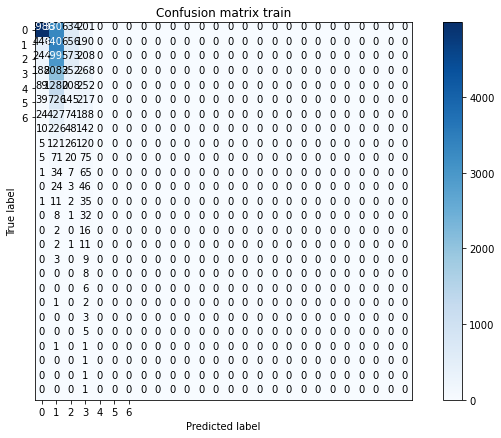

In [198]:
# Convertir dataframe a array
x = model_neuronal.predict(x_train)
y = y_train_transf.to_numpy()

# Matriz de confusión train
cm = confusion_matrix(y.argmax(axis=1),
                      x.argmax(axis=1))
np.set_printoptions(precision=2)
class_names = ['0','1', '2', '3', '4', '5', '6']
plt.figure(1, figsize=(9, 6))
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix train')
plt.savefig('graph/matriz_confusion_NNtrain_3.jpg')
plt.show()

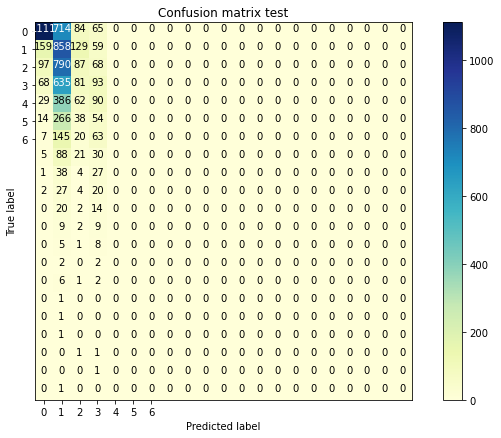

In [199]:
# Convertir dataframe a array
x = model_neuronal.predict(x_test)
y = y_test_transf.to_numpy()

# Matriz de confusión test
cm = confusion_matrix(y.argmax(axis=1),
                      x.argmax(axis=1))
np.set_printoptions(precision=2)
class_names = ['0','1', '2', '3', '4', '5', '6']
plt.figure(1, figsize=(9, 6))
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix test',
                      cmap="YlGnBu")
plt.savefig('graph/matriz_confusion_NNtest_3.jpg')
plt.show()